# Methods for Data Science: Course Work 2

In [1]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

In this question we will implement a multi-layer perceptron. Our network architure will involve an input layer, 3 hidden layers (200 neurons each), and an output layer (10 neurons). We will use the $\textbf{softplus}$ activation function as our activation function between each layer, the $\textbf{softmax}$ function as the activation function on the output layer, and the loss function as the $\textbf{KL divergence}$.


We will first read in the training and testing data that we need.

In [2]:
# read in training and testing data
MNIST_train = pd.read_csv("./MNIST_train.csv")
MNIST_test = pd.read_csv("./MNIST_test.csv")

In [3]:
# check the tails of our data
MNIST_train.tail(), MNIST_test.tail()

(      label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
 5995      1    0    0    0    0    0    0    0    0    0  ...      0      0   
 5996      1    0    0    0    0    0    0    0    0    0  ...      0      0   
 5997      4    0    0    0    0    0    0    0    0    0  ...      0      0   
 5998      5    0    0    0    0    0    0    0    0    0  ...      0      0   
 5999      8    0    0    0    0    0    0    0    0    0  ...      0      0   
 
       28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
 5995      0      0      0      0      0      0      0      0  
 5996      0      0      0      0      0      0      0      0  
 5997      0      0      0      0      0      0      0      0  
 5998      0      0      0      0      0      0      0      0  
 5999      0      0      0      0      0      0      0      0  
 
 [5 rows x 785 columns],
      label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
 995      0    0    0    0  

In [4]:
# separate the label from the image data
x_train_MNIST = MNIST_train[MNIST_train.columns.drop("label")]
y_train_MNIST = MNIST_train.loc[:, "label"]

x_test_MNIST = MNIST_test[MNIST_test.columns.drop("label")]
y_test_MNIST = MNIST_test.loc[:, "label"]

# to numpy arrays
x_train_MNIST = x_train_MNIST.to_numpy()
y_train_MNIST = y_train_MNIST.to_numpy()
x_test_MNIST = x_test_MNIST.to_numpy()
y_test_MNIST = y_test_MNIST.to_numpy()

The image data is filled with integer pixel values from 0 to 255. To facilitate the training, we rescale the values to the interval $[0, 1]$ and work with this scaled version of the data.

In [5]:
# Rescale the image data
x_train_MNIST_scaled = x_train_MNIST / 255.
x_test_MNIST_scaled = x_test_MNIST / 255.

Let us quickly verify the scaling worked.

In [6]:
# verify it was done correctly
print(f"min of training data {np.min(x_train_MNIST_scaled)},", f"max of training data {np.max(x_train_MNIST_scaled)}")
print(f"min of testing data {np.min(x_test_MNIST_scaled)},", f"max of testing data {np.max(x_test_MNIST_scaled)}")

min of training data 0.0, max of training data 1.0
min of testing data 0.0, max of testing data 1.0


 Below describes the layer transformations in the MLP, which we will need to implement:
\begin{align*}
\boldsymbol h^{(0)} &:= \boldsymbol x,\\
\boldsymbol a^{(1)} &= \boldsymbol W^{(0)} \boldsymbol h^{(0)} + \boldsymbol b^{(0)},\\
\boldsymbol h^{(1)} &= \textbf{softplus}\left(\boldsymbol{a}^{(1)}\right),\\
\boldsymbol a^{(2)} &= \boldsymbol W^{(1)} \boldsymbol h^{(1)} + \boldsymbol b^{(1)},\\
\boldsymbol h^{(2)} &= \textbf{softplus}\left(\boldsymbol{a}^{(2)}\right),\\
\boldsymbol a^{(3)} &= \boldsymbol W^{(2)} \boldsymbol h^{(2)} + \boldsymbol b^{(2)},\\
\boldsymbol h^{(3)} &= \textbf{softplus}\left(\boldsymbol{a}^{(3)}\right),\\
\boldsymbol a^{(4)} &= \boldsymbol W^{(3)} \boldsymbol h^{(3)} + \boldsymbol b^{(3)},\\
\hat{\boldsymbol y} &= \textbf{softmax}\left(\boldsymbol{a}^{(4)}\right),
\end{align*}
where $\boldsymbol x \in \mathbb{R}^{D}, \hat{\boldsymbol y} \in \mathbb{R}^{n_L}, \boldsymbol W^{(k)} \in \mathbb{R}{n_k \times n_{k+1}}, \boldsymbol b^{(k)} \in \mathbb{R}^{n_{k+1}}, \boldsymbol h^{(k)} \in \mathbb{R}^{n_k}, \quad k=0, 1, 2, 3.$

Note that $\textbf{Softplus}$ is evaluated element-wise over the entries of $\boldsymbol{a}^{(k)}$, whereas $\textbf{softmax}$ operates on all the entries of $\boldsymbol{a}^{(4)}$.

For our given network architecture specification, $L = 3$, $n_k = 200$ for $k=1, 2, 3$, and we have set $n_0:=D$, where D is the dimension of the sample being passed through the MLP, which is 784 for the images in our datasets.

Our first task is to implement the dense layer in `dense()`, which calculates the layer pre-activations $\boldsymbol a^{(k+1)}$ from given weight kernel $\boldsymbol W^{(k)}$ and bias $\boldsymbol b^{(k)}$, and layer input $\boldsymbol h^{(k)}$.

In [7]:
def dense(x, W, b):
    """
    Computes the layer pre-activations for given weight kernel and bias parameters.
    Args:
        x: K x n_k array of inputs.
        W: n_k x n_{k+1} array for weight kernel matrix parameters.
        b: Length n_{k+1} 1-D array for bias parameters.
    Returns:
        h: K x n_{k+1} output array of layer pre-activations.
    """
    # get pre-activations
    h = b + x @ W 
    return h

We now define `softplus()`, which is an implementation of the $\boldsymbol{softplus}$ function which we will use as our activation function between layers.

\begin{align}
\mathrm{Softplus}(x) = \frac{\mathrm{log}(1 + \mathrm{exp}(\beta x))}{\beta}.
\end{align}

The default value of $\beta$ in our function is 1 which is what we will use in our network.

In [8]:
def softplus(h, beta=1):
    """
    Applies the softplus function to a pre-activation given array
    to obtain array of post-activations.
    Args:
        h: K x n_k array of layer pre-activations.
        beta: Softplus parameter. Defaults to 1.
    Returns:
        h: K x n_k output array of layer post-activations.
    """
    h = np.log(1+np.exp(beta*h)) / beta
    return h

We also define `softmax()`, which is an implementation of the $\boldsymbol{softmax}$ function which we will use as our activation function on the output layer.

\begin{align}
\mathrm{Softmax}\left(\boldsymbol x\right)_i = \frac{\mathrm{exp}(x_i)}{\sum_j \mathrm{exp}(x_j)}.
\end{align}

In [9]:
def softmax(h):
    """
    Applies the softmax function across the rows of a given pre-activation array.
    Args:
        h: K x n_k array of layer pre-activations
    Returns:
        h: K x n_k output array of layer post-activations
    """
    h = np.exp(h)/np.sum(np.exp(h), axis=1, keepdims=True)
    return h

Let us represent our MLP neural network as a function $f_{\theta} : \mathbb{R}^{784} \rightarrow \mathbb{R}^{10}$, such that $f_{\theta}(x_i)$ is the output when input $x_i$ is passed through the MLP with parameters $\theta$.

We can now create the function `mlp()` which gives this output $f_{\theta}(x_i)$ for the $x_i$ passed in.

In [10]:
def mlp(x, W0, W1, W2, W3, b0, b1, b2, b3):
    """
    Passes an input array through a multi-layer perceptron with 3 hidden layers,
    for a given set of kernel and bias parameters. The softplus activation function is
    used between layers, and the softmax activation function is applied to the output layer.
    Args:
        x: K x 784 array of inputs
        W0: 784 x 200 array, the kernel matrix for input layer -> hidden layer 1.
        W1: 200 x 200 array, the kernel matrix for hidden layer 1 -> hidden layer 2.
        W2: 200 x 200 array, the kernel matrix for hidden layer 2 -> hidden layer 3.
        W3: 200 x 10 array, the kernel matrix for hidden layer 3 -> output layer.
        b0: Length 200 1-D array, the bias vector for input layer -> hidden layer 1.
        b1: Length 200 1-D array, the bias vector for hidden layer 1 -> hidden layer 2.
        b2: Length 200 1-D array, the bias vector for hidden layer 2 -> hidden layer 3.
        b3: Length 200 1-D array, the bias vector for hidden layer 3 -> output layer.
    Returns:
        y_hat: K x n_4 array of output layer post-activations.
    """
    a1 = dense(x, W0, b0) # hidden layer 1 pre-activations
    h1 = softplus(a1) # hidden layer 1 post-activations
    a2 = dense(h1, W1, b1) # hidden layer 2 pre-activations
    h2 = softplus(a2) # hidden layer 2 post-activations
    a3 = dense(h2, W2, b2) # hidden layer 3 pre-activations
    h3 = softplus(a3) # hidden layer 3 post-activations
    a4 = dense(h3, W3, b3) # output layer pre-activations
    y_hat = softmax(a4) # output layer post-activations
    return y_hat

To initialize our MLP, we will need some initial kernels and biases. We define `initialize_parameters()` to implement Glorot initialization, which initializes kernel values Gaussian distribution with zero mean and variance $\frac{2}{n_{k} + n_{k+1}}$. The bias parameters are initialized to zeros.

In [11]:
def initialize_parameters(n, neurons):
    """
    Initializes the kernel and bias parameters for a multi-layer perceptron with 3 hidden layers, using Glorot initialization.
    Args:
        n: Number of input features.
        neurons: Number of neurons in each hidden layer.
    Returns:
        W0: 784 x 200 array, the kernel matrix for input layer -> hidden layer 1.
        W1: 200 x 200 array, the kernel matrix for hidden layer 1 -> hidden layer 2.
        W2: 200 x 200 array, the kernel matrix for hidden layer 2 -> hidden layer 3.
        W3: 200 x 10 array, the kernel matrix for hidden layer 3 -> output layer.
        b0: Length 200 1-D array, the bias vector for input layer -> hidden layer 1.
        b1: Length 200 1-D array, the bias vector for hidden layer 1 -> hidden layer 2.
        b2: Length 200 1-D array, the bias vector for hidden layer 2 -> hidden layer 3.
        b3: Length 200 1-D array, the bias vector for hidden layer 3 -> output layer.
    """
    var0 = 2. / (neurons + n)
    W0 = np.random.randn(n, neurons) * np.sqrt(var0)
    b0 = np.zeros(neurons)

    var1 = 2. / (neurons + neurons)
    W1 = np.random.randn(neurons, neurons) * np.sqrt(var1)
    b1 = np.zeros(neurons)

    var2 = 2. /(neurons + neurons)
    W2 = np.random.randn(neurons, neurons) * np.sqrt(var2)
    b2 = np.zeros(neurons)

    var3 = 2. / (10 + neurons)
    W3 = np.random.randn(neurons, 10) * np.sqrt(var3)
    b3 = np.zeros(10)

    return W0, W1, W2, W3, b0, b1, b2, b3

We would like to use the $\textbf{KL divergence}$ as our loss function. In order to properly define how the loss is computed, we first define the discrete probability distribution $\mathcal{P}$ on $\mathcal{Y} := \{0, 1, \dots, 9\}$, which describes the ground truth probability distribution of an image $x_i$ being a certain digit.

Since the true digit $y_i$ of each image $x_i$ is known, $\mathcal{P(y)} = \mathbb{I}_{\{y=y_i\}}=\begin{cases}1 & y = y_i,\\ 0 & \text{otherwise}\end{cases}$.

This is also known as a one-hot encoding.

We now define another discrete probability distribution $\mathcal{Q}$ on $\mathcal{Y}$, which is the probability distribution for the predicted digit of image $x_i$ given by passing through $x_i$ through the MLP.

Now we evaluate the $\textbf{KL divergence}$ in terms of our probability distributions:

\begin{align}
L_{KL}(\mathcal{P}, \mathcal{Q}) &= \sum_{y\in \mathcal{Y}} \mathcal{P}(y)\mathrm{log}\left(\frac{\mathcal{P(y)}}{\mathcal{Q(y)}}\right),\\
&= \sum_{y\in \mathcal{Y}} \left(\mathcal{P}(y)\mathrm{log}\left(\mathcal{P(y)}\right) - \mathcal{P}(y)\mathrm{log}\left(\mathcal{Q(y)}\right)\right),\\
&= -\sum_{y\in \mathcal{Y}} \mathcal{P}(y)\mathrm{log}\left(\mathcal{Q(y)}\right), \quad \text{since } \mathcal{P}(y)\mathrm{log}\left(\mathcal{P(y)}\right)=0,\\
&= -\sum_{y\in \mathcal{Y}} \mathbb{I}_{\{y=y_i\}}\mathrm{log}\left(\mathcal{Q(y)}\right), \quad \text{where } \mathbb{I} \text{ is the indicator function}.
\end{align}

We can reformulate the above derivation as: 
\begin{align}
L_{KL}(y_i, f_{\theta}(x_i)) = -\sum_{k=0}^9 \mathbb{I}_{\{k=y_i\}}\mathrm{log}\left(\boldsymbol [f_{\theta}(x_i)]_k\right), \quad \text{where } [f_{\theta}(x_i)]_k \text{ is $k^{th}$ entry of }f_{\theta}(x_i).
\end{align}

We implement this formula in `kl_divergence()`.

In [12]:
def kl_divergence(y, y_hat):
    """
    Computes the KL divergence of our MLP's predictions for given kernel and bias parameters,
    using the true labels.
    Args:
        x: K x n_0 array of inputs.
        y: Length K 1-D array of true labels.
    Returns:
        kl_div: Length K 1-D array of KL divergences of each input.
    """
    # compute the KL divergence for each input
    kl_div = - np.log(np.array([y_hat[idx, value] for idx, value in enumerate(y)]))
    return kl_div

We will optimize our MLP parameters using stochastic gradient descent, which uses the parameter update rule $\theta_{t+1} = \theta_t - \eta \nabla_t L(\theta_t; \mathcal{D}_m), \quad t \in \mathbb{N}_0$.

In the above equation, $L(\theta_t; \mathcal{D}_m) = \frac{1}{M} \sum_{x_i, y_i \in \mathcal{D}_m} L_{KL}(y_i, f_{\theta_t}(x_i))$, where $\mathcal{D_m}$ is a randomly sampled minibatch, and $M = |\mathcal{D}_m|$.

For ease of notation we let $L_i := L_{KL}(y_i, f_{\theta_t}(x_i))$, the KL divergence loss evaluated at image $x_i$.

In order to obtain the term $\nabla_t L(\theta_t; \mathcal{D}_m)$, we will employ the backpropagation algorithm which proceeds as follows:

1) Propagate the signal forwards by passing an input vector $x_i$ through the MLP network and compute all pre-activations $\boldsymbol a^{(k)}$, and post-activations $\boldsymbol h^{(k)}$.

2) Evaluate $\delta^{(4)} = \frac{\partial L_i}{\partial \boldsymbol a^{(4)}}$.

3) Backpropagate the errors to compute $\delta^{(k)}$ for each hidden unit using $\delta^{(k)} = \mathrm{Softplus}^\prime\left(\boldsymbol a^{(k)}\right)\left(\boldsymbol W^{(k)}\right)^T\delta^{(k+1)}$.

4) Obtain the derivatives of the loss $L_i$ with respect to the weights and biases using $\frac{\partial L_i}{\partial w_{pq}^{(k)}} = \delta_p^{(k+1)}h_q^{(k)}$, $\frac{\partial L_i}{\partial b_p^{(k)}} = \delta_p^{(k+1)}$.

Note: $\mathrm{Softplus}^\prime(\boldsymbol a^{(k)})$ is the derivative of the $\textbf{softplus}$ function evaluated element-wise for each entry in $\boldsymbol a^{(k)}$.

After completing our forward pass through the MLP network, in order to get our output error $\delta^{(4)}$ in the second step, we must evaluate $\frac{\partial L_i}{\partial \boldsymbol a^{(4)}}$.

Let us take the derivative of $L_i$ with respect the $j^{th}$ component of $\boldsymbol a^{(4)}$:
\begin{align}
L_i &=  -\sum_{k=0}^9 \mathbb{I}_{\{k=y_i\}}\mathrm{log}\left([\boldsymbol f_{\theta}(x_i)]_k\right),\\
&= -\sum_{k=0}^9 \mathbb{I}_{\{k=y_i\}}\mathrm{log}\left(\hat{y}_k\right),\\
\implies \frac{\partial L_i}{\partial \boldsymbol a_j^{(4)}} &= -\sum_{k=0}^9 \mathbb{I}_{\{k=y_i\}}\frac{1}{\hat{y}_k} \left(\frac{\partial \hat{y}_k}{\partial \boldsymbol a_j^{(4)}}\right).
\end{align}

In the above expressions we have denoted $\hat{y}_k = [\boldsymbol f_{\theta}(x_i)]_k = \mathrm{Softmax}\left(\boldsymbol a^{(4)}\right)_k$, the $k^{th}$ entry of our output layer post-activations. We still need to find $\frac{\partial \hat{y}_k}{\partial \boldsymbol a_j^{(4)}}$, which we will do now.

Note that the outputs of the $\textbf{softmax}$ function are strictly positive values, so we can take the derivative of the logarithm of $\hat{y}_k$ with respect to $\boldsymbol a_j^{(4)}$:
\begin{align}
\frac{\partial}{\partial \boldsymbol a_j^{(4)}}\mathrm{log}(\hat{y}_k) &= \frac{1}{\hat{y}_k} \cdot \frac{\partial \hat{y}_k}{\partial \boldsymbol a_j^{(4)}},\\
\implies \frac{\partial \hat{y}_k}{\partial \boldsymbol a_j^{(4)}} &= \hat{y}_k \cdot \frac{\partial}{\partial \boldsymbol a_j^{(4)}}\mathrm{log}(\hat{y}_k).
\end{align}
This is the derivative we want. Let us try to simplify the derivative on the right-hand side:
\begin{align}
\mathrm{log}(\hat{y}_k) &= \mathrm{log}\left(\frac{\mathrm{exp}\left(\boldsymbol a_k^{(4)}\right)}{\sum_{l=0}^{9} \mathrm{exp}\left(\boldsymbol a_l^{(4)}\right)}\right),\\
&= \boldsymbol a_k^{(4)} - \mathrm{log}\left(\sum_{l=0}^{9} \mathrm{exp}\left(\boldsymbol a_l^{(4)}\right)\right),\\
\implies  \frac{\partial}{\partial \boldsymbol a_j^{(4)}}\mathrm{log}(\hat{y}_k) &= \frac{\partial\boldsymbol a_k^{(4)}}{\partial\boldsymbol a_j^{(4)}} - \frac{\mathrm{exp}\left(\boldsymbol a_j^{(4)}\right)}{\sum_{l=0}^{9} \mathrm{exp}\left(\boldsymbol a_l^{(4)}\right)},\\
&= \mathbb{I}_{\{k=j\}} - \mathrm{Softmax}\left(\boldsymbol a_j^{(4)}\right).
\end{align}
Substituting in:
\begin{align}
\frac{\partial \hat{y}_k}{\partial \boldsymbol a_j^{(4)}} &= \hat{y}_k \cdot \left(\mathbb{I}_{\{k=j\}} - \mathrm{Softmax}\left(\boldsymbol a_j^{(4)}\right)\right),\\
&= \hat{y}_k\left(\mathbb{I}_{\{k=j\}} - \hat{y}_j\right).
\end{align}

Finally, we can substitute this into the original equation:
\begin{align}
\frac{\partial L_i}{\partial \boldsymbol a_j^{(4)}} &= -\sum_{k=0}^9 \mathbb{I}_{\{k=y_i\}}\frac{1}{\hat{y}_k} \left(\frac{\partial \hat{y}_k}{\partial \boldsymbol a_j^{(4)}}\right),\\
&= -\sum_{k=0}^9 \mathbb{I}_{\{k=y_i\}}\frac{1}{\hat{y}_k} \left(\hat{y}_k\left(\mathbb{I}_{\{k=j\}} - \hat{y}_j\right)\right),\\
&= \sum_{k=0}^9 \mathbb{I}_{\{k=y_i\}}\hat{y}_j -\sum_{k=0}^9 \mathbb{I}_{\{k=y_i\}}\mathbb{I}_{\{k=j\}},\\
&= \hat{y}_j - \mathbb{I}_{\{j=y_i\}},\\
\implies \delta_j^{(4)} &= \hat{y}_j - \mathbb{I}_{\{j=y_i\}}.
\end{align}


Below, we implement this formula for $\delta^{(4)}$ in the function `output_error()`.

In [13]:
def output_error(y_hat, y, beta=1):
    """
    Compute the output error from the output layer post-activations and true labels.
    Args:
        y_hat: K x 10 array of output layer post-activations.
        y: Length K 1-D array of true labels.
    Returns:
        dkl: K x 10 array of output errors.
    """
    # copy the array of post-activations
    dkl = y_hat.copy()
    # subtract 1 from the post-activation of the true label
    for idx, label in enumerate(y):
        dkl[idx, label] -= 1
    return dkl

To perform the subsequent backpropagation steps to get $\delta^{(3)}$, $\delta^{(2)}$, and $\delta^{(1)}$, we will also need to use the derivative of our $\textbf{softplus}$ function. This is a straightforward derivation:
\begin{align}
\frac{\partial\mathrm{Softplus}(x)}{\partial x} &= \frac{1}{\beta(1 + \mathrm{exp}(\beta x))} \cdot \beta \mathrm{exp}(\beta x),\\
&= \frac{\mathrm{exp}(\beta x)}{1 + \mathrm{exp}(\beta x)}.
\end{align}

We implement this below in `softplus_derivative()`.

In [14]:
def softplus_derivative(a, beta=1):
    """
    Computes the derivative of the softplus activation function.
    Args:
        a: K x n_k array of pre-activations.
        beta: Softplus parameter.
    Returns:
        d: K x n_k array of derivatives.
    """
    dsoftplus = np.exp(beta * a) / (1 + np.exp(beta * a))
    return dsoftplus

We now define `backpropagate_step()` which is an implementation the third step in the algorithm above, where we backpropagate the error $\delta^{(k+1)}$ to obtain $\delta^{(k)}$.

In [15]:
def backpropagate_step(delta, W, a):
    """
    Perform a backpropagation step to compute the hidden layer errors.
    Args:
        delta: K x 1 array of errors.
        W: 64 x 1 array of weights.
        a: K x 64 array of hidden layer pre-activations.
    Returns:
        bakcpropagated_delta: K x 64 array of backpropagated hidden layer errors.
    """
    backpropagated_delta = np.squeeze((softplus_derivative(a)[:, :, np.newaxis] * W) @ delta[:, :, np.newaxis])

    return backpropagated_delta

Now we have the functionality to obtain all of our errors, we use the errors to perform our final step to obtain the derivatives of the loss function with respect to the weights and biases. The `grads()` function below will compute these losses for us.

In [16]:
def grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3):
    """
    Compute the gradients of the loss function with respect to the kernel and bias parameters.
    Args:
        delta1: K x 200 array of hidden layer 1 errors.
        delta2: K x 200 array of hidden layer 2 errors.
        delta3: K x 200 array of hidden layer 3 errors.
        delta4: K x 10 array of output errors.
        h0: K x 784 array of inputs.
        h1: K x 200 array of hidden layer post-activations.
        h2: K x 200 array of hidden layer post-activations.
        h3: K x 200 array of hidden layer post-activations.
    Returns:
        grad_W0: 784 x 200 array, the gradient of the loss function with respect to W0.
        grad_b0: Length 200 1-D array, the gradient of the loss function with respect to b0.
        grad_W1: 200 x 200 array, the gradient of the loss function with respect to W1.
        grad_b1: Length 200 1-D array, the gradient of the loss function with respect to b1.
        grad_W2: 200 x 200 array, the gradient of the loss function with respect to W2.
        grad_b2: Length 200 1-D array, the gradient of the loss function with respect to b2.
        grad_W3: 200 x 10 array, the gradient of the loss function with respect to W3.
        grad_b3: Length 10 1-D array, the gradient of the loss function with respect to b3.
    """
    # use our errors to calculate the gradients of our parameters
    grad_W0 = delta1[:, np.newaxis, :] * h0[:, :, np.newaxis]
    grad_b0 = delta1
    grad_W1 = delta2[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b1 = delta2
    grad_W2 = delta3[:, np.newaxis, :] * h2[:, :, np.newaxis]
    grad_b2 = delta3
    grad_W3 = delta4[:, np.newaxis, :] * h3[:, :, np.newaxis]
    grad_b3 = delta4
    
    # take the average gradients
    grad_W0 = grad_W0.mean(axis=0)
    grad_b0 = grad_b0.mean(axis=0)
    grad_W1 = grad_W1.mean(axis=0)
    grad_b1 = grad_b1.mean(axis=0)
    grad_W2 = grad_W2.mean(axis=0)
    grad_b2 = grad_b2.mean(axis=0)
    grad_W3 = grad_W3.mean(axis=0)
    grad_b3 = grad_b3.mean(axis=0)
    
    return grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3

Since we are going to use stochastic gradient descent, we need to split the data into batches. We use randomly sampled batches instead of shuffling the data at each epoch and taking uniform batch splits. We implement `random_batch_indexes()` below to obtain the indexes of our batch split.

In [17]:
def random_batch_indexes(N, batch_size):
    """
    Create a list of random batch indexes.
    Args:
        N: Size of dataset.
        batch_size: Size of each batch.
    Returns:
        
    """
    # create a random list of indexes
    index_perm = np.random.permutation(np.arange(N))
    # split the indexes into batches
    batches = np.split(index_perm, np.arange(batch_size,len(index_perm),batch_size))
    return batches

We will also define `mlp_accuracy()` below to calculate the accuracy of the prediction output of our MLP network.

In [18]:
def mlp_accuracy(y, y_hat):
    """
    Compute the accuracy of the MLP's predictions.
    Args:
        y: Length K 1-D array of true labels.
        y_hat: K x 10 array of output layer post-activations.
    Returns:
        accuracy: Scalar, the accuracy of the MLP's predictions.
    """
    # make the predictions based on the highest post-activation
    y_pred = np.argmax(y_hat, axis=1)
    # compute the accuracy
    accuracy = np.mean(y_pred==y)
    return accuracy

Combining all of our functions together, we create the function `sgd()` which performs the stochastic gradient descent optimization of the MLP parameters by iterating the steps 1-4 we described earlier over all of the batches in the random batch split, for every epoch. This is repeated for the number of epochs desired.

In [19]:
def sgd(x_train, y_train, x_test, y_test, epochs=40, learning_rate=1.0e-3, batch_size=128, neurons=200, return_losses=False, return_accuracies=False, dropout_rate = None):
    """
    Train an MLP using stochastic gradient descent.
    Args:
        x_train: N x 784 array of training inputs.
        y_train: Length N 1-D array of training labels.
        x_test: M x 784 array of test inputs.
        y_test: Length M 1-D array of test labels.
        epochs: Number of epochs to train for.
        learning_rate: Learning rate to use in stochastic gradient descent.
        batch_size: Size of each batch.
        neurons: Number of neurons in each hidden layer.
        return_losses: Boolean, whether to return the training and test losses.
        return_accuracies: Boolean, whether to return the training and test accuracies.
        dropout_rate: Float, the probability of dropping out a neuron if passed in.
    Returns:
        W0: 784 x 200 array, the trained kernel parameters for the first hidden layer.
        W1: 200 x 200 array, the trained kernel parameters for the second hidden layer.
        W2: 200 x 200 array, the trained kernel parameters for the third hidden layer.
        W3: 200 x 10 array, the trained kernel parameters for the output layer.
        b0: Length 200 1-D array, the trained bias parameters for the first hidden layer.
        b1: Length 200 1-D array, the trained bias parameters for the second hidden layer.
        b2: Length 200 1-D array, the trained bias parameters for the third hidden layer.
        b3: Length 10 1-D array, the trained bias parameters for the output layer.
        train_losses: Length epochs 1-D array, the training loss at each epoch.
        test_losses: Length epochs 1-D array, the test loss at each epoch.
        train_accuracies: Length epochs 1-D array, the training accuracy at each epoch.
        test_accuracies: Length epochs 1-D array, the test accuracy at each epoch.
    """
    # initialize parameters
    W0, W1, W2, W3, b0, b1, b2, b3 = initialize_parameters(x_train.shape[1], neurons)
    # initial forward pass
    y_train_pred = mlp(x_train, W0, W1, W2, W3, b0, b1, b2, b3)
    y_test_pred = mlp(x_test, W0, W1, W2, W3, b0, b1, b2, b3)
    print(f"epoch 0, training loss is {kl_divergence(y_train, y_train_pred).mean()}")
    # initialize train and test losses array with inital losses
    if return_losses:
        train_losses = [kl_divergence(y_train, y_train_pred).mean()]
        test_losses = [kl_divergence(y_test, y_test_pred).mean()]
    # initialize train and test accuracies array with initial accuracies
    if return_accuracies:
        train_acc = [mlp_accuracy(y_train, y_train_pred)]
        test_acc = [mlp_accuracy(y_test, y_test_pred)]
    nth = 0
    for epoch in range(epochs):
        # create batch indexes
        batch_indexes = random_batch_indexes(x_train.shape[0], batch_size)
        for batch in batch_indexes:
            # slice out the batch
            x_batch = x_train[batch, :]
            y_batch = y_train[batch]
            # forward pass
            if dropout_rate is not None:
                # use MLP with dropout if dropout_rate is passed in
                a1 = dense(x_batch, W0, b0)
                h1 = softplus(a1)
                # get bernoulli dropout mask for first hidden layer, and rescale the non-dropped out units by 1/(1-dropout_rate)
                u1 = np.random.binomial(1, 1-dropout_rate, size=h1.shape) / (1-dropout_rate)
                h1 *= u1
                a2 = dense(h1, W1, b1)
                h2 = softplus(a2)
                # get bernoiulli dropout mask for second hidden layer, and rescale the non-dropped out units by 1/(1-dropout_rate)
                u2 = np.random.binomial(1, 1-dropout_rate, size=h2.shape) / (1-dropout_rate)
                h2 *= u2
                a3 = dense(h2, W2, b2)
                h3 = softplus(a3)
                # get bernoulli dropout mask for third hidden layer, and rescale the non-dropped out units by 1/(1-dropout_rate)
                u3 = np.random.binomial(1, 1-dropout_rate, size=h3.shape) / (1-dropout_rate)
                h3 *= u3
                a4 = dense(h3, W3, b3)
            else:
                # use MLP without dropout if dropout_rate is not passed in
                a1 = dense(x_batch, W0, b0)
                h1 = softplus(a1)
                a2 = dense(h1, W1, b1)
                h2 = softplus(a2)
                a3 = dense(h2, W2, b2)
                h3 = softplus(a3)
                a4 = dense(h3, W3, b3)
            y_hat = softmax(a4)
            # backward pass
            if dropout_rate is not None:
                delta4 = output_error(y_hat, y_batch)
                delta3 = backpropagate_step(delta4, W3, a3)
                # apply scaled bernoulli mask to delta3 during backpropagation
                delta3 *= u3
                delta2 = backpropagate_step(delta3, W2, a2)
                # apply scaled bernoulli mask to delta2 during backpropagation
                delta2 *= u2
                delta1 = backpropagate_step(delta2, W1, a1)
                # apply scaled bernoulli mask to delta1 during backpropagation
                delta1 *= u1
            else:
                delta4 = output_error(y_hat, y_batch)
                delta3 = backpropagate_step(delta4, W3, a3)
                delta2 = backpropagate_step(delta3, W2, a2)
                delta1 = backpropagate_step(delta2, W1, a1)
            # calculate gradients
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, delta4, x_batch, h1, h2, h3)
            # update parameters
            W0 -= learning_rate * grad_W0
            b0 -= learning_rate * grad_b0
            W1 -= learning_rate * grad_W1
            b1 -= learning_rate * grad_b1
            W2 -= learning_rate * grad_W2
            b2 -= learning_rate * grad_b2
            W3 -= learning_rate * grad_W3
            b3 -= learning_rate * grad_b3
        # print training loss every 2**nth epoch
        if epoch == 2**nth-1 or epoch==epochs-1:
            y_train_pred = mlp(x_train, W0, W1, W2, W3, b0, b1, b2, b3)
            print("epoch {}, training loss is {}".format(epoch+1, kl_divergence(y_train, y_train_pred).mean()))
            nth += 1
        # append losses
        if return_losses:
            y_train_pred = mlp(x_train, W0, W1, W2, W3, b0, b1, b2, b3)
            y_test_pred = mlp(x_test, W0, W1, W2, W3, b0, b1, b2, b3)
            train_losses.append(kl_divergence(y_train, y_train_pred).mean())
            test_losses.append(kl_divergence(y_test, y_test_pred).mean())
        # appened accuracies
        if return_accuracies:
            y_train_pred = mlp(x_train, W0, W1, W2, W3, b0, b1, b2, b3)
            y_test_pred = mlp(x_test, W0, W1, W2, W3, b0, b1, b2, b3)
            train_acc.append(mlp_accuracy(y_train, y_train_pred))
            test_acc.append(mlp_accuracy(y_test, y_test_pred))
        
    if return_losses and return_accuracies:
        return W0, W1, W2, W3, b0, b1, b2, b3, train_losses, test_losses, train_acc, test_acc
    elif return_losses:
        return W0, W1, W2, W3, b0, b1, b2, b3, train_losses, test_losses
    elif return_accuracies:
        return W0, W1, W2, W3, b0, b1, b2, b3, train_acc, test_acc
    else:
        return W0, W1, W2, W3, b0, b1, b2, b3

We have now implemented everything we need to train our MLP.

We will now train the MLP for seven learning rates $\eta \in [10^{-5}, 10^{-1}]$ as instructed, using batches of 128 data points, 200 hidden layer width, and running 40 epochs.

In [20]:
# set seed for reproducibility
np.random.seed(1)
# initialize range of learning rates to test
learning_rate_range = np.linspace(1e-5, 1e-1, 7)
# initialize dictionary to store final training losses for each learning rate
final_train_loss_map = {}
for learning_rate in learning_rate_range:
    print(f"starting training for learning rate: {learning_rate}")
    # train MLP for the current learning rate
    train_losses = sgd(x_train_MNIST_scaled, y_train_MNIST, x_test_MNIST_scaled, y_test_MNIST, epochs=40, learning_rate=learning_rate, batch_size=128, neurons=200, return_losses=True)[-2]
    # store final training loss for the current learning rate
    final_train_loss_map[learning_rate] = train_losses[-1]
    print("learning_rate: {}, final training loss: {}".format(learning_rate, train_losses[-1]))

starting training for learning rate: 1e-05
epoch 0, training loss is 2.613835244698446
epoch 1, training loss is 2.607602948485652
epoch 2, training loss is 2.601553617074887
epoch 4, training loss is 2.5899847246039855
epoch 8, training loss is 2.5686912607330337
epoch 16, training loss is 2.532063991047423
epoch 32, training loss is 2.475396139606694
epoch 40, training loss is 2.452893098460264
learning_rate: 1e-05, final training loss: 2.452893098460264
starting training for learning rate: 0.016675000000000002
epoch 0, training loss is 2.917328390671917
epoch 1, training loss is 2.2501671758826842
epoch 2, training loss is 2.178619601544883
epoch 4, training loss is 1.8856258426594765
epoch 8, training loss is 0.9720852361201447
epoch 16, training loss is 0.4880260661618616
epoch 32, training loss is 0.35913952757916895
epoch 40, training loss is 0.33098638983777656
learning_rate: 0.016675000000000002, final training loss: 0.33098638983777656
starting training for learning rate: 0.0

We provide a visualization of the final loss achieved as learning rate is varied below.

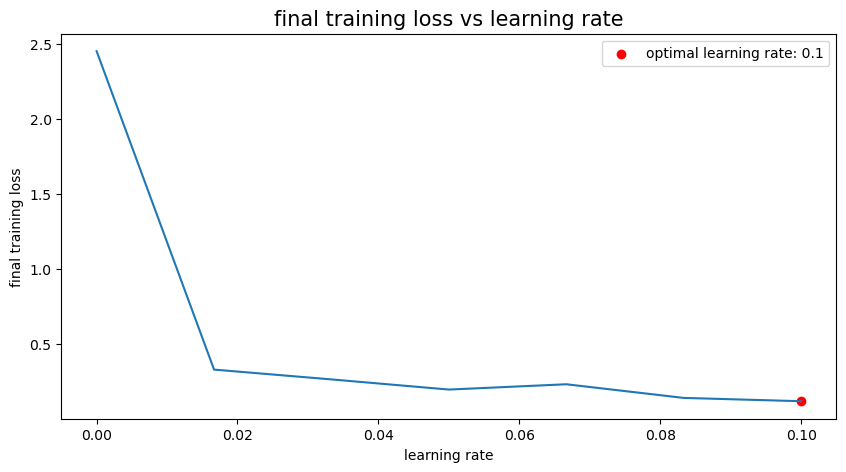

In [21]:
# create plot
plt.figure(figsize=(10, 5))
plt.plot(final_train_loss_map.keys(), final_train_loss_map.values())
plt.xlabel("learning rate")
plt.ylabel("final training loss")
plt.title("final training loss vs learning rate", fontsize=15)
# get the optimal learning rate
optimal_learning_rate = min(final_train_loss_map, key=final_train_loss_map.get)
# mark the optimal learning rate and the corresponding loss
plt.scatter(optimal_learning_rate, final_train_loss_map[optimal_learning_rate], color="red", label=f"optimal learning rate: {optimal_learning_rate}")
plt.legend()


We explicitly report the optimal learning rate we found below.

In [22]:
print("optimal learning rate: {}".format(optimal_learning_rate))

optimal learning rate: 0.1


The plot above shows that the final training loss achieved by the MLP appears to decrease as the learning rate is increased from $10^{-5}$ to $10^{-1}$, with an optimal learning rate of 0.1.

1.1.2

We will now retrain the MLP using the optimal learning rate we found, again using batches of 128 data points, 200 hidden layer width, and running 40 epochs.

In [23]:
# set seed for reproducibility
np.random.seed(2)
# train MLP with optimal learning rate
W0, W1, W2, W3, b0, b1,b2, b3, optimal_train_losses, optimal_test_losses, optimal_train_acc, optimal_test_acc = sgd(x_train_MNIST_scaled, y_train_MNIST, x_test_MNIST_scaled, y_test_MNIST, epochs=40, learning_rate=optimal_learning_rate, batch_size=128, neurons=200, return_losses=True, return_accuracies=True)

epoch 0, training loss is 2.77878224234704
epoch 1, training loss is 2.018700320135525
epoch 2, training loss is 1.2072487610771183
epoch 4, training loss is 1.452900331116183
epoch 8, training loss is 0.6893141017708999
epoch 16, training loss is 0.30684598566644156
epoch 32, training loss is 0.18427418295220116
epoch 40, training loss is 0.14534277390688286


We plot the loss and accuracy of the MLP on both the training and testing data as a function of the number of epochs below.

Text(0.5, 0.98, '200 Hidden Layer Width')

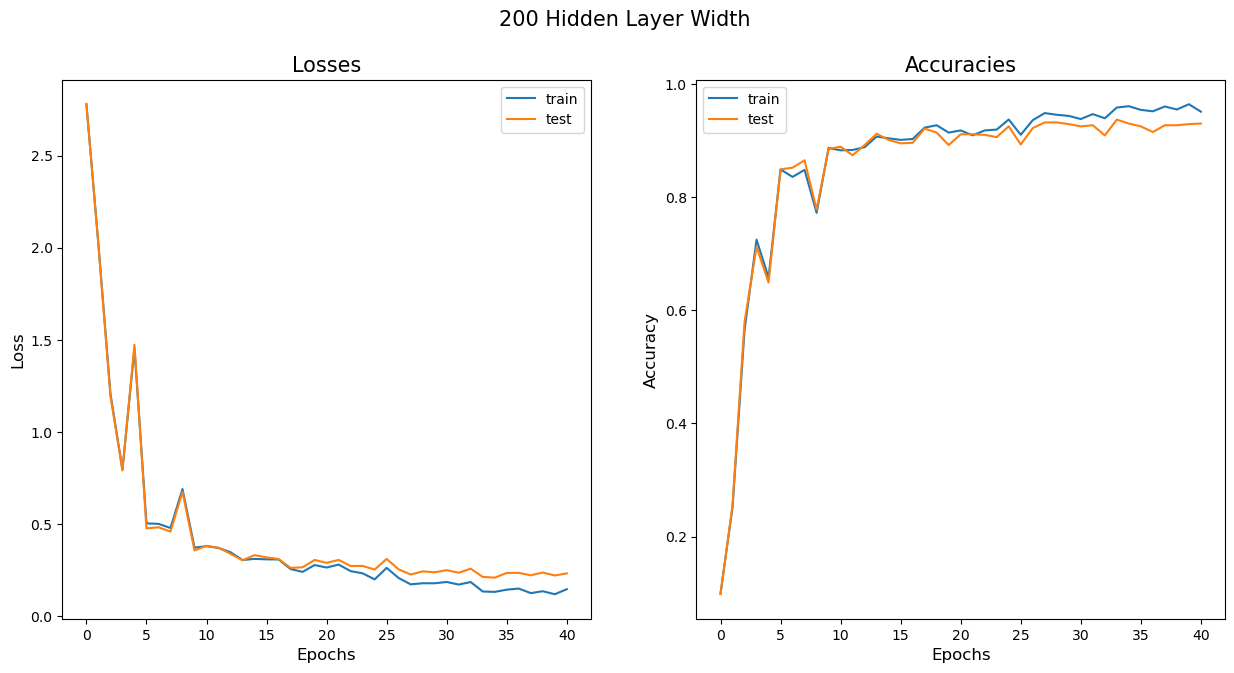

In [24]:
# create plot
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# plot losses
axs[0].plot(np.arange(41), optimal_train_losses, label="train")
axs[0].plot(np.arange(41), optimal_test_losses, label="test")
axs[0].set_title("Losses", fontsize=15)
axs[0].set_xlabel("Epochs", fontsize=12)
axs[0].set_ylabel("Loss", fontsize=12)
axs[0].legend()
# plot accuracies
axs[1].plot(np.arange(41), optimal_train_acc, label="train")
axs[1].plot(np.arange(41), optimal_test_acc, label="test")
axs[1].set_title("Accuracies", fontsize=15)
axs[1].set_xlabel("Epochs", fontsize=12)
axs[1].set_ylabel("Accuracy", fontsize=12)
axs[1].legend()
fig.suptitle("200 Hidden Layer Width", fontsize=15)

From the graph, we see that as the number of epochs is increased, the loss of both the training and testing sets decreases, and the accuracy of both the training and testing sets increases; this is the behaviour we expect from our training process.

We also see that the MLP has very similar performance on both the training set and the testing sets up until around 15 epochs, after which increasing the number of epochs appears to improve the MLP's performance slightly more on the training set compared to the testing set. This behaviour is likely caused by the MLP parameters becoming more overfitted on our training data as we increase the number of epochs, since it is used in our training process; overfitting will cause the model to perform better on the training data, whilst not giving much improvement to the unseen testing data.

1.1.3

We will now train an MLP using the same optimal learning rate we found earlier, but this time we will use a hidden layer width of 50. We will still use batches of 128 data points, and run 40 epochs as before.

In [25]:
# set seed for reproducibility
np.random.seed(4)
# train MLP with optimal learning rate
reduced_train_losses, reduced_test_losses, reduced_train_acc, reduced_test_acc = sgd(x_train_MNIST_scaled, y_train_MNIST, x_test_MNIST_scaled, y_test_MNIST, epochs=40, learning_rate=optimal_learning_rate, batch_size=128, neurons=50, return_losses=True, return_accuracies=True)[-4:]

epoch 0, training loss is 3.0993829459736655
epoch 1, training loss is 1.9747696576483456
epoch 2, training loss is 0.9799350728584213
epoch 4, training loss is 0.583779999408483
epoch 8, training loss is 0.4007881863781467
epoch 16, training loss is 0.24502897670948603
epoch 32, training loss is 0.162061633506554
epoch 40, training loss is 0.08414174155429584


We plot the loss and accuracy of the reduced hidden layer width MLP on both the training and testing data as a function of the number of epochs below.

Text(0.5, 0.98, '50 Hidden Layer Width')

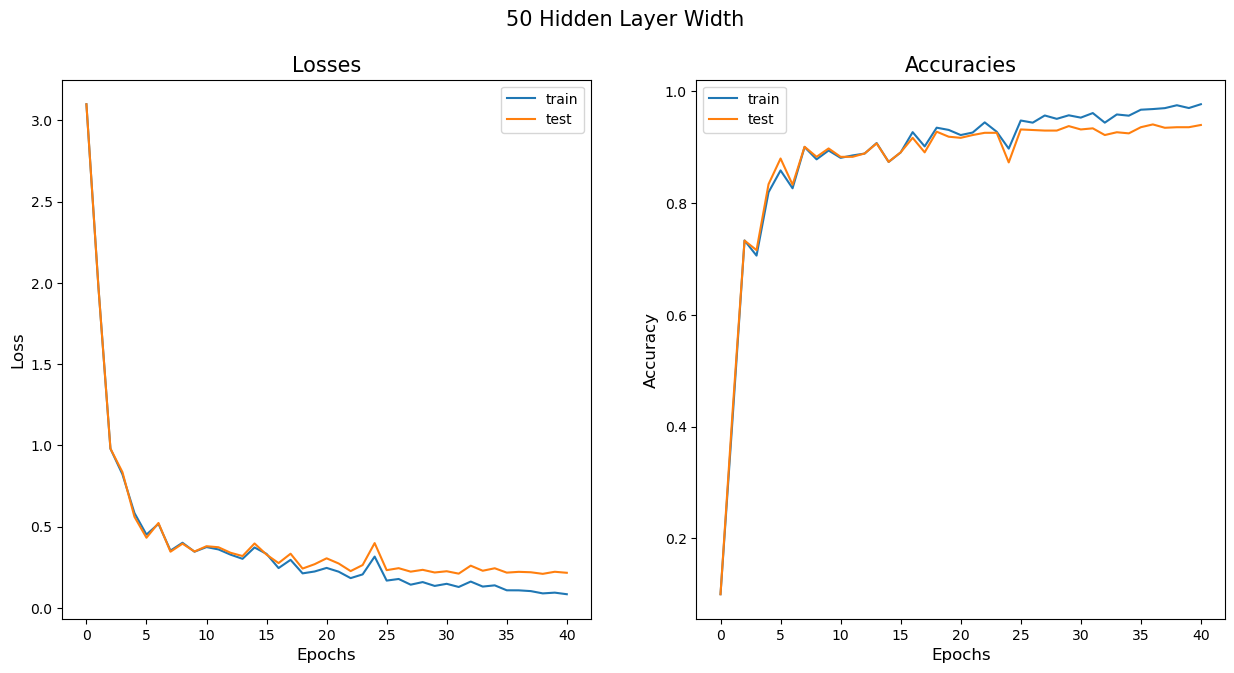

In [26]:
# create plot
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# plot losses
axs[0].plot(np.arange(41), reduced_train_losses, label="train")
axs[0].plot(np.arange(41), reduced_test_losses, label="test")
axs[0].set_title("Losses", fontsize=15)
axs[0].set_xlabel("Epochs", fontsize=12)
axs[0].set_ylabel("Loss", fontsize=12)
axs[0].legend()
# plot accuracies
axs[1].plot(np.arange(41), reduced_train_acc, label="train")
axs[1].plot(np.arange(41), reduced_test_acc, label="test")
axs[1].set_title("Accuracies", fontsize=15)
axs[1].set_xlabel("Epochs", fontsize=12)
axs[1].set_ylabel("Accuracy", fontsize=12)
axs[1].legend()
fig.suptitle("50 Hidden Layer Width", fontsize=15)

The graphs of loss and accuracy vs number of epochs for the 50 hidden layer width MLP model appears to be almost identical to that of the 200 hidden layer width MLP model. We compare the final training set and testing set accuracies in a table below to aid our comparison.

In [27]:
# construct dataframe to store accuracies
mlp_accuracy_array = np.zeros((2, 2))
mlp_accuracy_array[0, 0] = optimal_train_acc[-1] # final train accuracy 200 neuron
mlp_accuracy_array[0, 1] = optimal_test_acc[-1] # final test accuracy 200 neuron
mlp_accuracy_array[1, 0] = reduced_train_acc[-1] # final train accuracy 50 neuron
mlp_accuracy_array[1, 1] = reduced_test_acc[-1] # final test accuracy 50 neuron
mlp_columns = ["final training accuracy", "final testing accuracy"]
mlp_index = ["200 hidden layer width MLP", "50 hidden layer width MLP"]
# create comparison table
mlp_accuracy_df = pd.DataFrame(mlp_accuracy_array, index=mlp_index, columns=mlp_columns)
mlp_accuracy_df

,final training accuracy,final testing accuracy
200 hidden layer width MLP,0.951000,0.93
50 hidden layer width MLP,0.977167,0.94


We see that in terms of accuracy, the 50 hidden layer width MLP actually performs better than the 200 hidden layer width MLP on the training set, and it is even slightly better in terms of testing accuracy. This suggests that we can use a $\textbf{simpler}$ neural network with fewer hidden layer neurons (50 per layer) to achieve equal performance on the testing data as the network with 200 per hidden layer; by the principle of parsimony we would prefer to use the 50 hidden layer width network as it has less complexity, with equally good performance. The main benefit of using the simpler 50 hidden layer width network is that it has a lot fewer weight and bias parameters to store and train, and so it is more efficient to train in terms of time and computational power.

The reason for this may be that we do not have enough/appropriate data to train the 200 hidden layer width MLP effectively, as it has a lot more complexity than the 50 hidden layer width MLP.

1.1.4

We provide support for the MLP with dropout functionality in our `sgd()` function through the keyword argument $\textit{dropout}\_\textit{rate}$.

In order to implement the dropout, we apply a Bernoulli mask to the post-activations of each hidden layer; this mask zeros each post-activation with probability $\textit{dropout}\_\textit{rate}$. Since after each dropout step we should be left with (on average) only $1-\textit{dropout}\_\textit{rate}$ of the original post-activations, we also scale the remaining post-activations by $\frac{1}{1 - \textit{dropout}\_\textit{rate}}$ to compensate for this.

We also ensure that we apply the Bernoulli mask and re-scaling to the errors during the backpropagation.

As suggested in the question, we will use a larger number of epochs (80) to train our MLP with dropout, since it is discussed in literature [1] that dropout roughly doubles the number of iterations required to converge compared to when using no dropout. We also use a larger learning rate (0.2) as suggested, as we notice that the loss struggles to converge as well when using smaller learning rates.

In [28]:
# set random seed for reproducibility
np.random.seed(2)
# set dropout rate
dropout_rate = 0.2
# train MLP with dropout
dropout_W0, dropout_W1, dropout_W2, dropout_W3, dropout_b0, dropout_b1, dropout_b2, dropout_b3, dropout_train_losses, dropout_test_losses, dropout_train_acc, dropout_test_acc = sgd(x_train_MNIST_scaled, y_train_MNIST, x_test_MNIST_scaled, y_test_MNIST, epochs=80, learning_rate=0.2, batch_size=128, neurons=200, return_losses=True, return_accuracies=True, dropout_rate=dropout_rate)

epoch 0, training loss is 2.77878224234704
epoch 1, training loss is 2.0938315930932525
epoch 2, training loss is 1.248714413340676
epoch 4, training loss is 0.6075157925652488
epoch 8, training loss is 0.43690032104995286
epoch 16, training loss is 0.2800939651431524
epoch 32, training loss is 0.15337073991353645
epoch 64, training loss is 0.07347966059675329
epoch 80, training loss is 0.04867111813975178


We will plot the loss and accuracies on the training and testing sets as a function of number of epochs like before.

Text(0.5, 0.98, '200 Hidden Layer Width, dropout_rate=0.2')

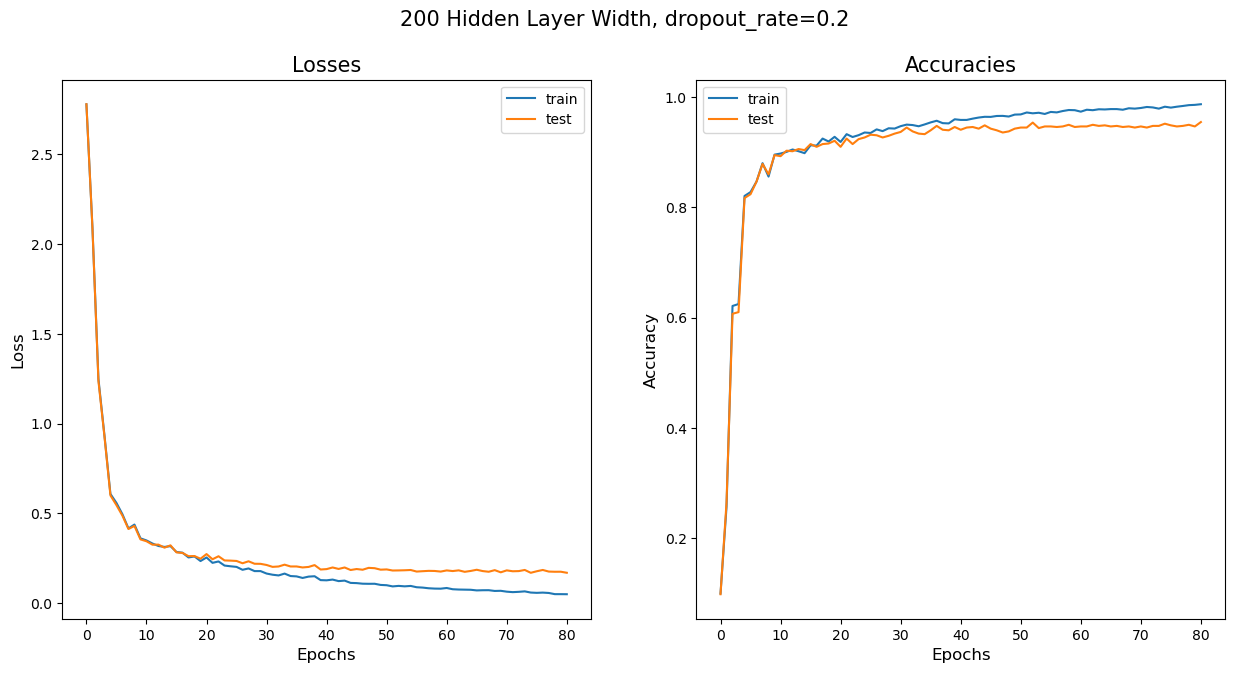

In [29]:
# create plot
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# plot losses
axs[0].plot(np.arange(81), dropout_train_losses, label="train")
axs[0].plot(np.arange(81), dropout_test_losses, label="test")
axs[0].set_title("Losses", fontsize=15)
axs[0].set_xlabel("Epochs", fontsize=12)
axs[0].set_ylabel("Loss", fontsize=12)
axs[0].legend()
# plot accuracies
axs[1].plot(np.arange(81), dropout_train_acc, label="train")
axs[1].plot(np.arange(81), dropout_test_acc, label="test")
axs[1].set_title("Accuracies", fontsize=15)
axs[1].set_xlabel("Epochs", fontsize=12)
axs[1].set_ylabel("Accuracy", fontsize=12)
axs[1].legend()
fig.suptitle(f"200 Hidden Layer Width, dropout_rate={dropout_rate}", fontsize=15)

We can see from our plot that we have convergence as our losses decrease and become almost constant (curve becomes flat) as the number of epochs increases.

We add the final training set and testing set accuracies to our previous comparison table to help us compare later.

In [30]:
# add dropout results to table
mlp_accuracy_array_2 = np.vstack((mlp_accuracy_array, np.array([dropout_train_acc[-1], dropout_test_acc[-1]])))
mlp_index_2 = ["200 hidden layer width MLP", "50 hidden layer width MLP", "200 hidden layer width MLP with dropout"]
mlp_accuracy_df_2 = pd.DataFrame(mlp_accuracy_array_2, index=mlp_index_2, columns=mlp_columns)

Let us now take a random batch of size 128 from our testing set.

In [31]:
# set seed for reproducibility
np.random.seed(69)
# take a random batch of 128 samples from the test set
random_batch_indexes = np.random.randint(0, x_test_MNIST_scaled.shape[0], size=128)
x_test_scaled_batch = x_test_MNIST_scaled[random_batch_indexes]

We will pass this random batch of 128 test data points through the first hidden layer of the MLP with dropout, and visualize these post-activations in a histogram.

(0.0, 1.0)

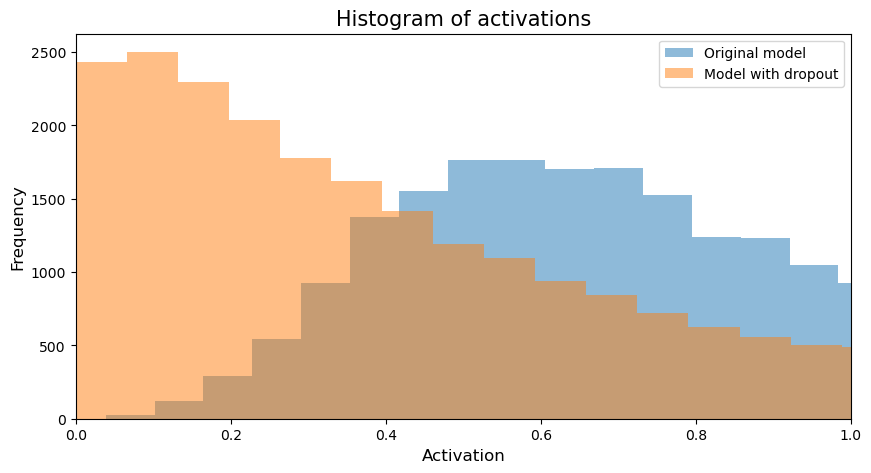

In [32]:
# get activations for the random batch using the original model
a1 = dense(x_test_scaled_batch, W0, b0)
h1 = softplus(a1)

# get activations for the random batch using the model with dropout
dropout_a1 = dense(x_test_scaled_batch, dropout_W0, dropout_b0)
dropout_h1 = softplus(dropout_a1)

# plot histograms
plt.figure(figsize=(10, 5))
plt.hist(h1.flatten(), bins=100, label="Original model", alpha=0.5)
plt.hist(dropout_h1.flatten(), bins=100, label="Model with dropout", alpha=0.5)
plt.title("Histogram of activations", fontsize=15)
plt.xlabel("Activation", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.xlim(0, 1)

In [33]:
mlp_accuracy_df_2

,final training accuracy,final testing accuracy
200 hidden layer width MLP,0.951000,0.930
50 hidden layer width MLP,0.977167,0.940
200 hidden layer width MLP with dropout,0.987333,0.955


First, from our comparison table, we can see that our MLP with dropout performs noticably better on both the training set and testing set than the other two MLP networks that do not have dropout implemented. The improved performance on the testing dataset of the MLP with dropout suggests that the dropout implementation has been successful in reducing the overfitting of the neural network on the training set, which is one of the main motivations for using an MLP with dropout since it should reduce co-adaption of units in the neural network. One thing to bear in mind is that whilst we see that the MLP with dropout performs better than the MLP without dropout on our testing data, it comes at the cost of taking longer to train the model as we doubled the number of epochs to ensure convergence.

Also, from observing the distributions in the histogram above, we can see that the post-activation units of the original MLP model without dropout appear to be distributed in a way resembling a Gaussian distribution, with a mean of around 0.6. However, we see the effect of dropout in action when we observe the units of the MLP model with dropout, which appear to be more skewed towards zero in their distribution, and there appears to be a higher proportion of units with value zero compared with the MLP without dropout. This is expected since dropout should have zeroed out post-activation units with probability $0.2$, and we can see it working in the differences between the number of zeroed out units in the two models.

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

We will first read in the noisy training and testing data that we will work with in this section.

In [34]:
# read in noisy training and testing data
MNIST_noisy_train = pd.read_csv("./MNIST_train_noisy.txt", sep=" ", header=None)
MNIST_noisy_test = pd.read_csv("./MNIST_test_noisy.txt", sep=" ", header=None)

# check tails
MNIST_noisy_train.tail(), MNIST_noisy_test.tail()

(           0         1         2          3         4         5         6    \
 5995 -10.95780   4.51461   2.71595 -18.023900  18.26510 -11.52160  23.48780   
 5996   9.94383  22.31970  12.51530 -28.779900   4.53878  31.11730  -7.02403   
 5997   2.58476  28.15170   9.19486  30.679800  -7.40887 -12.61470  15.91990   
 5998 -41.01780  20.68240  28.48240 -14.782400  -3.69732 -18.63410 -19.88030   
 5999  12.81710 -11.91370 -22.35690   0.134061 -10.25990  -9.24673 -28.31900   
 
            7         8         9    ...       774        775       776  \
 5995 -26.50590  25.61000 -33.37270  ...  -7.47956  -2.028120 -12.11580   
 5996  12.14420  11.00700  -5.50289  ...  -5.73205 -17.500500  -9.01901   
 5997 -14.98460  -7.76000  -5.83204  ...   4.02516  -0.743738 -19.30600   
 5998  -5.87351   1.52842   9.69290  ... -16.33170   0.184736  10.71730   
 5999  -4.97316  30.32650   7.38784  ...   1.07617 -28.168600 -27.83630   
 
            777       778       779       780       781       782 

In [35]:
# to numpy arrays
x_train_MNIST_noisy = MNIST_noisy_train.to_numpy()
x_test_MNIST_noisy = MNIST_noisy_test.to_numpy()

The normalization steps below ensure that our image data will have zero mean and one variance, and make it ready to perform PCA on:

1. Convert unsigned interger 8 (uint8) encoding of pixels to a floating point number between 0 and 1.


In [36]:
# step 1 of normalization
x_train_MNIST_noisy_scaled = x_train_MNIST_noisy / 255
x_test_MNIST_noisy_scaled = x_test_MNIST_noisy / 255

2. Subtract from each image the mean $\boldsymbol \mu$.
3. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation.

The `normalize_pca()` function below helps us perform these last two normalization steps.

In [37]:
def normalize_pca(X_train, X_test=None):
    """
    Normalizes the data for PCA. Can also simultaneously normalize test
    data using the mean and standard deviation of the training data.
    Args:
        X_train: N x 784 array of training data
        X_test: K x 784 array of test data
    Returns:
        X_train_bar: N x 784 array of normalized training data
        X_test_bar: K x 784 array of normalized test data
        mu: 1 x 784 array, mean of training data columns
        std: 1 x 784 array, standard deviation of training data columns
    """
    # get mean and standard deviation
    mu = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    # normalize X_train
    X_train_bar = ((X_train-mu)/std_filled)
    if X_test is None:
        return X_train_bar, mu, std
    else:
        # normalize X_test by same transformation
        X_test_bar = ((X_test-mu)/std_filled)
        return X_train_bar, X_test_bar, mu, std

In [38]:
# normalize our noisy training and testing data
x_train_MNIST_noisy_norm, x_test_MNIST_noisy_norm, x_train_MNIST_noisy_mu, x_train_MNIST_noisy_std = normalize_pca(x_train_MNIST_noisy_scaled, x_test_MNIST_noisy_scaled)

In order to perform Principal Component Analysis on our normalized data $\boldsymbol X$, we follow the steps below:
1. Compute the covariance matrix $\boldsymbol C = \frac{1}{n-1}\boldsymbol X^T \boldsymbol X$, where $n$ is the number of data points in $\boldsymbol X$.
2. Find the eigenvalues and corresponding eigenvectors for the covariance matrix.
3. Sort the largest $m$ eigenvalues in descending order, and do the same for the corresponding $m$ eigenvectors.
4. Project $\boldsymbol X$ onto the space spanned by the top $m$ eigenvectors to get $\boldsymbol X_{PCA}$.

This projection matrix onto the first $m$ principal components, $\boldsymbol X_{PCA} \in \mathbb{R}^{n\times m}$, is given by the formula: $[\boldsymbol X_{PCA}]_{ij} = \boldsymbol (X^{(i)})^T \cdot \boldsymbol \phi_j^*$, where $\boldsymbol \phi_j^*$ is the eigenvector of the covariance matrix $\boldsymbol C$ that has the $j^{th}$ largest eigenvalue, and $\boldsymbol {X^{(i)}}$ is the $i^{th}$ data point in the normalized data $\boldsymbol X$. 

We now define `pca()` which helps us perform PCA.

In [39]:
def pca(X, k, return_variance=False):
    """
    Function that performs PCA on a dataset X using k principal components.
    Args:
        X: K x 784 array to perform PCA on.
        k: number of principal components to use.
        return_variance: boolean, if True, return the variance explained by the k principal components.
    Returns:
        X_pca: K x k array of the projected data.
        eigenvectors: 784 x k array of the eigenvectors.
        eigenvalues: 1 x k array of the eigenvalues.
        explained_variance: float, the variance explained by the k principal components.
    """
    # create covariance matrix S
    C = 1.0/(len(X)-1) * np.dot(X.T, X)


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    if k < C.shape[1]:
        eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(C, k, which="LM", return_eigenvectors=True)
    # use scipy.linalg.eigh if using all principal components
    else:
        eigenvalues, eigenvectors = scipy.linalg.eigh(C)

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X @ eigenvectors

    # return the variance explained by the k principal components if return_variance is True
    if return_variance:
        # compute the total variance by summing the eigenvalues
        all_eigenvalues = np.linalg.eig(C)[0]
        total_variance = abs(all_eigenvalues.sum())
        # compute the variance explained by the k principal components
        explained_variance = np.sum(eigenvalues) / total_variance
        return explained_variance
    else:
        return X_pca, eigenvectors, eigenvalues

Using this function we can now explore how the fraction of variance explained by PCA changes as we increase the number of principal components $m$.

In [40]:
# create a dictionary to store the variance explained by the k principal components
variance_dict = {}
# vary m from 1 to 784 (all principal components)
m_range = np.arange(1, 785)
# compute the variance explained by the k principal components for each m
for m in m_range:
    variance_dict[m] = pca(x_train_MNIST_noisy_norm, m, return_variance=True)

Let us plot the explained variance against the number of principal components $m$ below.

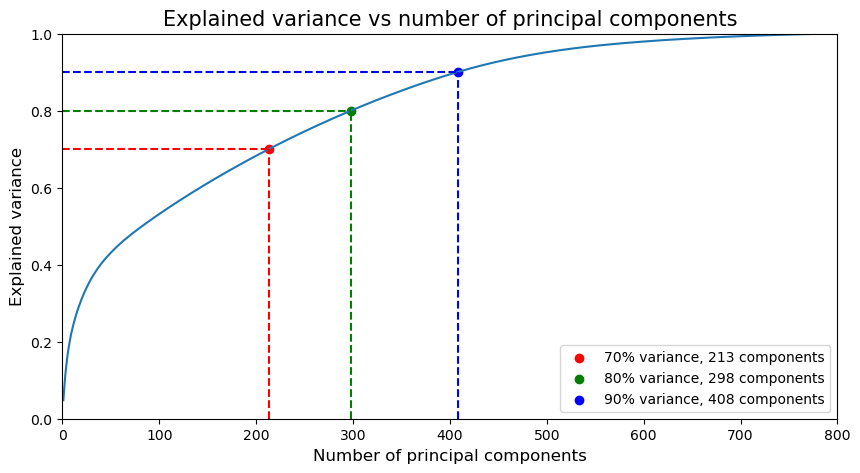

In [41]:
# get the number of principal components that explain 70%, 80%, and 90% of the variance
m_70 = [m for m, v in variance_dict.items() if v > 0.7][0]
m_80 = [m for m, v in variance_dict.items() if v > 0.8][0]
m_90 = [m for m, v in variance_dict.items() if v > 0.9][0]

# create plot
plt.figure(figsize=(10, 5))
plt.plot(variance_dict.keys(), variance_dict.values())
plt.xlabel("Number of principal components", fontsize=12)
plt.ylabel("Explained variance", fontsize=12)
plt.title("Explained variance vs number of principal components", fontsize=15)
# mark key variance points on curve
plt.scatter(m_70, variance_dict[m_70], label=f"70% variance, {m_70} components", color="red")
plt.scatter(m_80, variance_dict[m_80], label=f"80% variance, {m_80} components", color="green")
plt.scatter(m_90, variance_dict[m_90], label=f"90% variance, {m_90} components", color="blue")
# draw lines for visualization
plt.axvline(x=m_70, ymax=variance_dict[m_70], color="red", linestyle="--")
plt.axhline(y=variance_dict[m_70], xmax=(m_70)/800, color="red", linestyle="--")
plt.axvline(x=m_80, ymax=variance_dict[m_80], color="green", linestyle="--")
plt.axhline(y=variance_dict[m_80], xmax=(m_80)/800, color="green", linestyle="--")
plt.axvline(x=m_90, ymax=variance_dict[m_90], color="blue", linestyle="--")
plt.axhline(y=variance_dict[m_90], xmax=(m_90)/800, color="blue", linestyle="--")
plt.xlim(0, 800)
plt.ylim(0, 1)
plt.legend()

We explicitly report the number of principle components required to explain 70%, 80%, and 90% of the variance below.

In [42]:
print(f"70% variance explained with {m_70} components")
print(f"80% variance explained with {m_80} components")
print(f"90% variance explained with {m_90} components")

70% variance explained with 213 components
80% variance explained with 298 components
90% variance explained with 408 components


Now we will visualize the first $m=10$ principal components obtained from performing PCA on our normalized noisy training data.

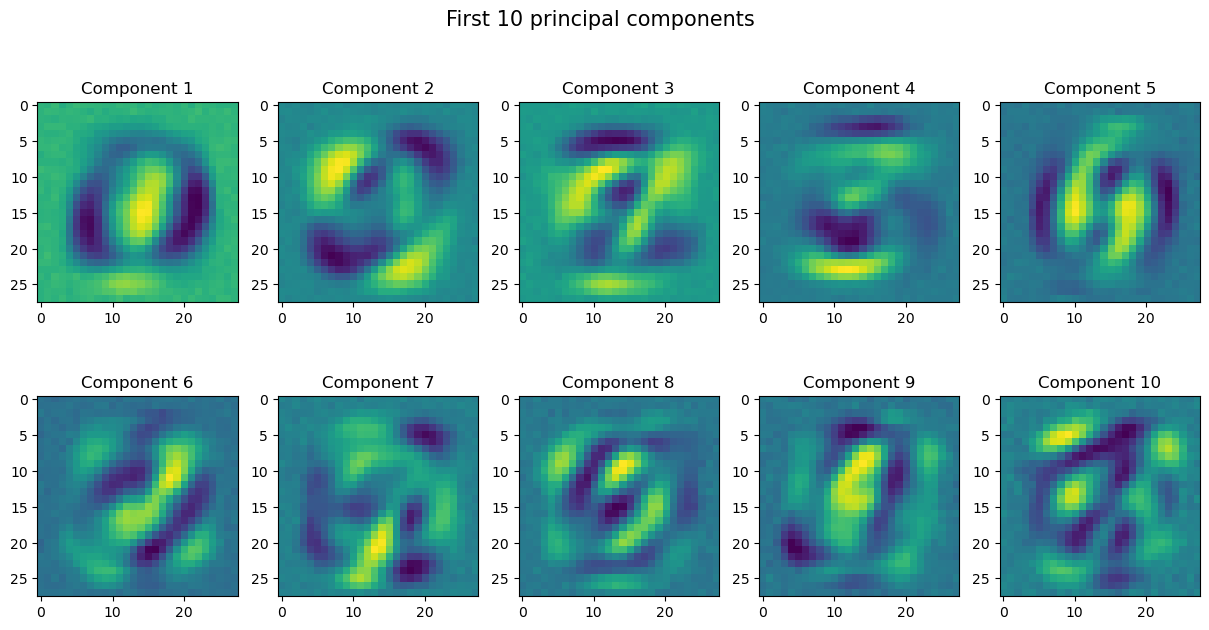

In [43]:
# get first 10 principal components
eigenvectors = pca(x_train_MNIST_noisy_norm, 10)[1]

# plot pca principle components
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(15,7))
fig.suptitle("First 10 principal components", fontsize=15)
for i,ax in enumerate(axs.reshape(-1)):
    ax.imshow(eigenvectors[:,i].reshape([28,28])) # unflatten pixel array
    ax.set_title(f"Component {str(i+1)}", fontsize=12)

1.2.2

To perform dimensionality reduction using the Non-negative Matrix Factorisation (NMF), we require the input matrix to be non-negative. Therefore, we must normalize between 0 and 1 instead of the standard normalization which we used for PCA.

In [44]:
def normalize_nmf(X_train, X_test = None):
    """
    Function that normalizes the data for NMF. Can also simultaneously normalize test
    data using the min and max of the training data.
    Args:
        X_train: N x 784 array of training data
        X_test: K x 784 array of test data
    Returns:
        X_train_norm: N x 784 array of normalized training data
        X_test_norm: K x 784 array of normalized test data
        min: float, the minimum value of the data.
        max: float, the maximum value of the data.
    """
    # normalize min max to 0-1
    min = np.min(X_train)
    max = np.max(X_train)
    # normalize X_train
    X_train_norm = (X_train - min) / (max - min)
    if X_test is not None:
        # normalize X_test
        X_test_norm = (X_test - min) / (max - min)
        return X_train_norm, X_test_norm, min, max
    else:
        return X_train_norm, min, max

# normalize the data for nmf
x_train_MNIST_noisy_nmf = normalize_nmf(x_train_MNIST_noisy)[0]

The NMF of non-negative normalized $\boldsymbol X$ is the factorisation $\boldsymbol X \approx \boldsymbol W \boldsymbol H$, where $\boldsymbol W$ and $\boldsymbol H$ are matrices with non-negative elements. We can find these matrices numerically using Lee and Seung's multiplicative update rule. The update rule is as follows:

\begin{align}
\mathbf{H}_{[i,j]}^{n+1}&\leftarrow \mathbf{H}_{[i,j]}^{n} 
\frac{(( \mathbf{W}^n)^T \mathbf{X})_{[i,j]}}{((\mathbf{W}^n)^T \mathbf{W}^n \mathbf{H}^n)_{[i,j]}},\\
\mathbf{W}_{[i,j]}^{n+1}&\leftarrow \mathbf{W}_{[i,j]}^{n}
\frac{(\mathbf{X}(\mathbf{H}^{n+1})^T)_{[i,j]}}{(\mathbf{W}^n \mathbf{H}^{n+1} (\mathbf{H}^{n+1})^T)_{[i,j]}},
\end{align}

until $\mathbf{W}$ and $\mathbf{H}$ are stable.

For the cost function in our optimisation, we will use the $\chi^2$ which we define as the root mean square residuals between our original feature matrix X and the product of our two factored matrices:

\begin{align}
\chi^2 = \frac{e^⊤ (X \odot d \odot d) e}{ n},
\end{align}

where d is the difference $d = X - WH$, and e is a vector of all ones where $e^⊤ K e$ simply performs a sum over all elements in K, $n$ is the total number of elements in $X$, and the symbol $\odot$ is the element wise product (Hadamard product).


This cost function is implemented in `nmf_cost()` below.

In [45]:
# lets define a cost function for our NMF
def nmf_cost(X, W, H):
    """
    Function that computes the cost function for NMF.
    Args:
        X: K x 784 array of the data.
        W: K x k array of the basis vectors.
        H: k x 784 array of the coefficients.
    Returns:
        chi2: float, the cost function
    """
    # compute the difference between X and the dot product of W and H
    diff = X - W @ H
    chi2 = np.mean(X * diff * diff)

    return chi2

We can now create the function `nmf()` below which implements Lee and Seung's multiplicative update rule for calculating the NMF.

In [46]:
def nmf(n_iters, X, k, return_loss=False):
    """
    Calculate the NMF decomposition of X.
    Args:
        n_iters: int, the number of iterations to run the algorithm.
        X: K x 784 array of the data.
        k: int, the number of components to project onto.
        return_loss: bool, whether to return the loss or not.
    Returns:
        W: K x k array of the basis vectors.
        H: k x 784 array of the coefficients.
        chi2: list of floats, the loss at each iteration.
    """
    # m x k components matrix, usually interpreted as the coefficients, where m is the number of data
    W = np.random.rand(X.shape[0], k)

    # k x n matrix interpreted as the basis set, where n is the number of features (e.g. pixels)
    H = np.random.rand(k, X.shape[1])
    # empty list for chi2 
    chi2 = []
    nth = 0
    print(f"iteration 0, cost is {nmf_cost(X,W,H)}")
    # loop over the n iterations
    for i in range(n_iters):

        # compute the update on H
        H = H * ((W.T.dot(X)) / W.T.dot(W.dot(H)))

        # compute the update on W
        W = W * ((X.dot(H.T)) / (W.dot(H.dot(H.T))))
        # print training loss every 2**nth epoch
        if i == 2**nth-1 or i==n_iters-1:
            print(f"iteration {i+1}, cost is  {nmf_cost(X,W,H)}")
            nth += 1
        # compute the chi2 and append to list
        chi2.append(nmf_cost(X,W,H))
    if return_loss:
        return W, H, chi2
    else:
        return W, H


We now use this to obtain the NMF of our normalized noisy training set with 10 dimensions to project the data onto. We run 500 iterations, and then plot the cost against iteration number.

iteration 0, cost is 1.5140366583835052
iteration 1, cost is  0.013373776533825758
iteration 2, cost is  0.013237341217252318
iteration 4, cost is  0.013111624637805878
iteration 8, cost is  0.012924935432355164
iteration 16, cost is  0.012573628780436037
iteration 32, cost is  0.010553505098466101
iteration 64, cost is  0.008043818635658478
iteration 128, cost is  0.007364470514865364
iteration 256, cost is  0.007191690155040322
iteration 500, cost is  0.007092952556489075


Text(0.5, 1.0, 'Cost vs iteration')

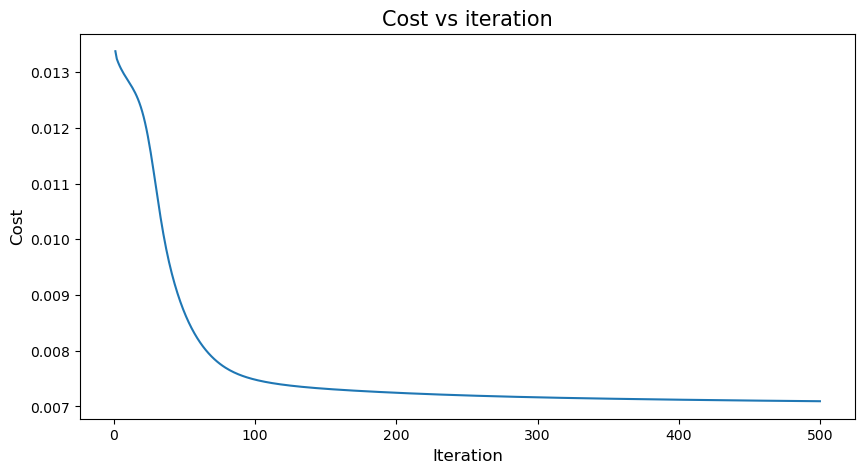

In [47]:
# set seed for repoducibility
np.random.seed(1)
# get the nmf decomposition of the data with 10 components, 500 iterations
W, H, chi2 = nmf(500, x_train_MNIST_noisy_nmf, 10, return_loss=True)

# plotting the cost
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, 501), chi2)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.title("Cost vs iteration", fontsize=15)

We see from our plot that our cost decreases as iteration number increases, and appears very flat for the last 100 iterations; this suggests we have chosen a sufficient number of iterations as we observe that there is very little improvement in the cost as we perform further iterations.

Now we will visualize the first $m=10$ NMF components obtained from getting the NMF of our normalized noisy training data.

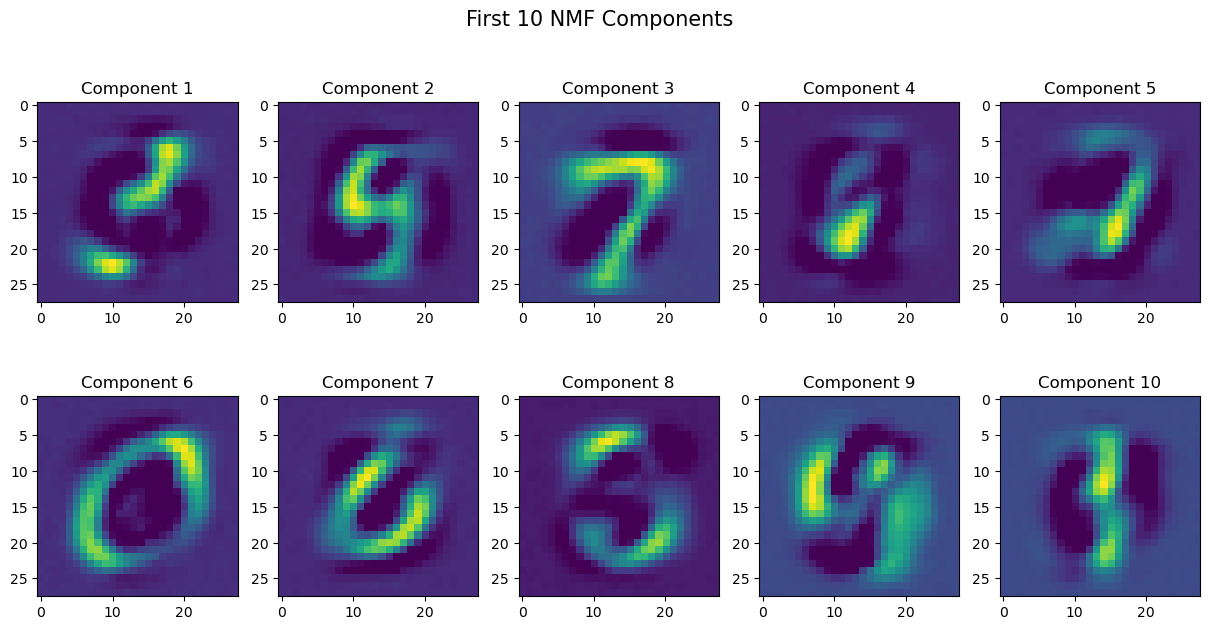

In [48]:
# plot nmf components
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(15,7))
fig.suptitle("First 10 NMF Components", fontsize=15)
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(H[i,:].reshape([28,28])) # unflatten pixel array
    ax.set_title(f"Component {str(i+1)}", fontsize=12)

We can see that the 10 components derived from our NMF appear to be slightly different to those derived from PCA, particularly in terms of colour and in their resemblance to the original images. This difference could be explained by the fact that the two dimensionality reduction methods work in different ways; the principal components found by PCA are identified as a subspace that preserves the variance of the dataset with no other constraints, whereas NMF essentially finds non-negative equivalents of these principal components.

Due to the constraint about the sign's of the NMF component elements, when approximating an image using the non-negative coefficeints in $\boldsymbol W$, it is only possible to make additions of the components of $\boldsymbol H$; this combination of components do not cancel either due to non-negativity of component entries. Because of the inability of the components to subtract and cancel with each other by the non-negativity, the components of NMF must be some kind of additive building blocks of the original images, and so that may be why we see the NMF components resembling the actual images in their colour distribution more than the PCA components; some of the NMF components almost appear to be faint digits. The basis image components of NMF can be seen as a "parts-based" represenation of our original images, whilst the PCA basis images can be seen as a holistic representation of the original images. [3]

However, we see that components found from PCA appear mainly green in colour and do not resemble any of the original images very much at all. Since there are no constraints on the signs of the PCA components and their coefficients, it is likely that there are many cancellations going on between the components when combined with the coefficients to approximate an image, and so the individual components do not necessarily have to resemble the actual images at all.

1.2.3

The steps we need to take in order to successfully denoise our noisy test images using the noisy training images using PCA are as follows:
1. Perform normalization of the training images using `normalize_pca()`, and apply the same transformation to the testing images. Store the $\mu$ and $\sigma$ used for this.
2. Perform PCA on the normalized noisy training images using `pca()` to obtain the first 100 principal components.
3. Project our normalized noisy testing images onto the first 100 principal components we found in the previous step, using the formula $[\boldsymbol X_{PCA}]_{ij} = \boldsymbol (X^{(i)})^T \cdot \boldsymbol \phi_j^*$, where $\boldsymbol X^{(i)}$ is the $i^{th}$ normalized noisy testing image and $\boldsymbol \phi_j^*$ is the $j^{th}$ principal component of the normalized noisy training images. We can do this because the $\boldsymbol \phi_j^*$'s are orthogonal.
4. Approximate our normalized testing data from the projections using the formula $\hat{\boldsymbol X}^{(i)} = \sum_{j=1}^m \boldsymbol [X_{PCA}]_{ij} \cdot \boldsymbol \phi_j^* = \sum_{j=1}^m\left((X^{(i)})^T \cdot \boldsymbol \phi_j^*\right)\cdot \boldsymbol \phi_j^*$ as we defined earlier.
5. Reverse the normalizing transformation we applied at the beginning to obtain our final denoised image.

These steps are implemented in the function `denoise_pca()` below.

In [49]:
def denoise_pca(X_train, X_test, k):
    """
    Denoise the testing data using the first
    100 principal components of the training data.
    Args:
        X_train: K x 784 array of the training data.
        X_test: K x 784 array of the testing data.
        k: int, the number of principal components to project onto.
    Returns:
        X_test_denoised: K x 784 array of the denoised testing data.
    """
    # normalize training and test images
    X_train_bar, X_test_bar, mu, std = normalize_pca(X_train, X_test)
    # compute first k pca components
    eigenvectors = pca(X_train_bar, k)[1]
    # approximate test images
    X_test_denoised_normalized = X_test_bar @ eigenvectors @ eigenvectors.T
    # reverse normalization
    X_test_denoised = (X_test_denoised_normalized * std + mu)
    return X_test_denoised

The steps to denoise our noisy test images using NMF are slightly different, as the components found in the $\boldsymbol H$ are not necessarily orthogonal.

Let us state some important results before we propose our algorithm. The NMF of a matrix $\boldsymbol X$ is actually the solution to the least-squares problem [2][3]:
\begin{align}
&\min_{\boldsymbol W, \boldsymbol H} \| \boldsymbol W \boldsymbol H - \boldsymbol X \|_F^2,\\
= &\min_{\boldsymbol W, \boldsymbol H} \| \boldsymbol H^T \boldsymbol W^T - \boldsymbol X^T \|_F^2, \quad \text{where } \|\cdot\|_F \text{ is the Frobenius norm}.
\end{align}

So given the $\boldsymbol H_{train}$ from the NMF of our normalized training images, we would like to project our normalized testing images $\boldsymbol X_{test}$ onto these NMF components. In other words, we would like to find $\boldsymbol W_{test}$ such that:
\begin{align}
    \boldsymbol W_{test} = &\min_{\boldsymbol W} \| \boldsymbol H_{train}^T \boldsymbol W^T - \boldsymbol X_{test}^T \|_F^2.
\end{align}
The minimizer to this least-squares problem is actually given by $\left(\boldsymbol {H}_{train}^T\right)^+ \boldsymbol X_{test}^T$, where $\left(\boldsymbol {H}_{train}^T\right)^+$ is the Moore-Penrose inverse (pseudoinverse) of $\boldsymbol {H}_{train}^T$ [4].

It follows then that our projections of $\boldsymbol X_{test}$ onto the first 100 NMF components of the normalized training data are given by $\boldsymbol X_{test}\left(\left(\boldsymbol {H}_{train}^T\right)^+\right)^T \boldsymbol H_{train}$.

Therefore, we can denoise by:
1. Perform normalization of the training images using `normalize_pca()`, and apply the same transformation to the testing images. Store the min and max used for this.
2. Obtain $\boldsymbol H_{train}$ from the NMF of our normalized training images using `nmf()`, whose rows contain the first 100 NMF components.
3. Approximate our normalized testing data using the first 100 NMF components by computing the quantity $\boldsymbol X_{test}\left(\left(\boldsymbol {H}_{train}^T\right)^+\right)^T \boldsymbol H_{train}$.
5. Reverse the normalizing transformation we applied at the beginning to obtain our final denoised image.


These steps are implemented in the function `denoise_nmf()` below.

In [50]:
def denoise_nmf(X_train, X_test, k, n_iters=500):
    """
    Denoise the testing data using the first
    100 NMF components of the training data.
    Args:
        X_train: K x 784 array of the training data.
        X_test: K x 784 array of the testing data.
        k: int, the number of NMF components to project onto.
        n_iters: int, the number of iterations to run the NMF algorithm.
    Returns:
        X_test_denoised: K x 784 array of the denoised testing data.
    """
    # normalize training and test images
    X_train_scaled, X_test_scaled, min, max = normalize_nmf(X_train, X_test)
    # compute first k NMF components
    W, H = nmf(n_iters, X_train_scaled, k)
    # approximate test images
    X_test_denoised_normalized = X_test @ np.linalg.pinv(H.T).T @ H
    # reverse normalization
    X_test_denoised = (X_test_denoised_normalized * (max - min) + min)
    return X_test_denoised

Now we have defined the functions that help us denoise, let us utilize them to help denoise our noisy training images.

Note that below, although we pass in the images pixels scaled on a 0 to 1 scale, we scale the denoised output back up by 255 so that it is on the original 0 to 255 pixel scale, and compariable with the original raw images as they were originally imported.

In [51]:
# denoise using PCA
x_test_pca_denoised_scaled = denoise_pca(x_train_MNIST_noisy_scaled, x_test_MNIST_noisy_scaled, 100)
# scale back up by 255
x_test_pca_denoised = x_test_pca_denoised_scaled * 255
# denoise using NMF
x_test_nmf_denoised_scaled = denoise_nmf(x_train_MNIST_noisy_scaled, x_test_MNIST_noisy_scaled, 100)
# scale back up by 255
x_test_nmf_denoised = x_test_nmf_denoised_scaled * 255

iteration 0, cost is 190.94995237334743
iteration 1, cost is  0.012773131049865764
iteration 2, cost is  0.012690380967698514
iteration 4, cost is  0.012643761840809323
iteration 8, cost is  0.012528437273110666
iteration 16, cost is  0.011983196980279909
iteration 32, cost is  0.007833177959656138
iteration 64, cost is  0.004014573356573617
iteration 128, cost is  0.00254857699063397
iteration 256, cost is  0.002044553656144727
iteration 500, cost is  0.001828991375635099


Now, for 5 random images, let us visualize the denoised version using PCA, denoised version using NMF, the noisy version, and the original version.

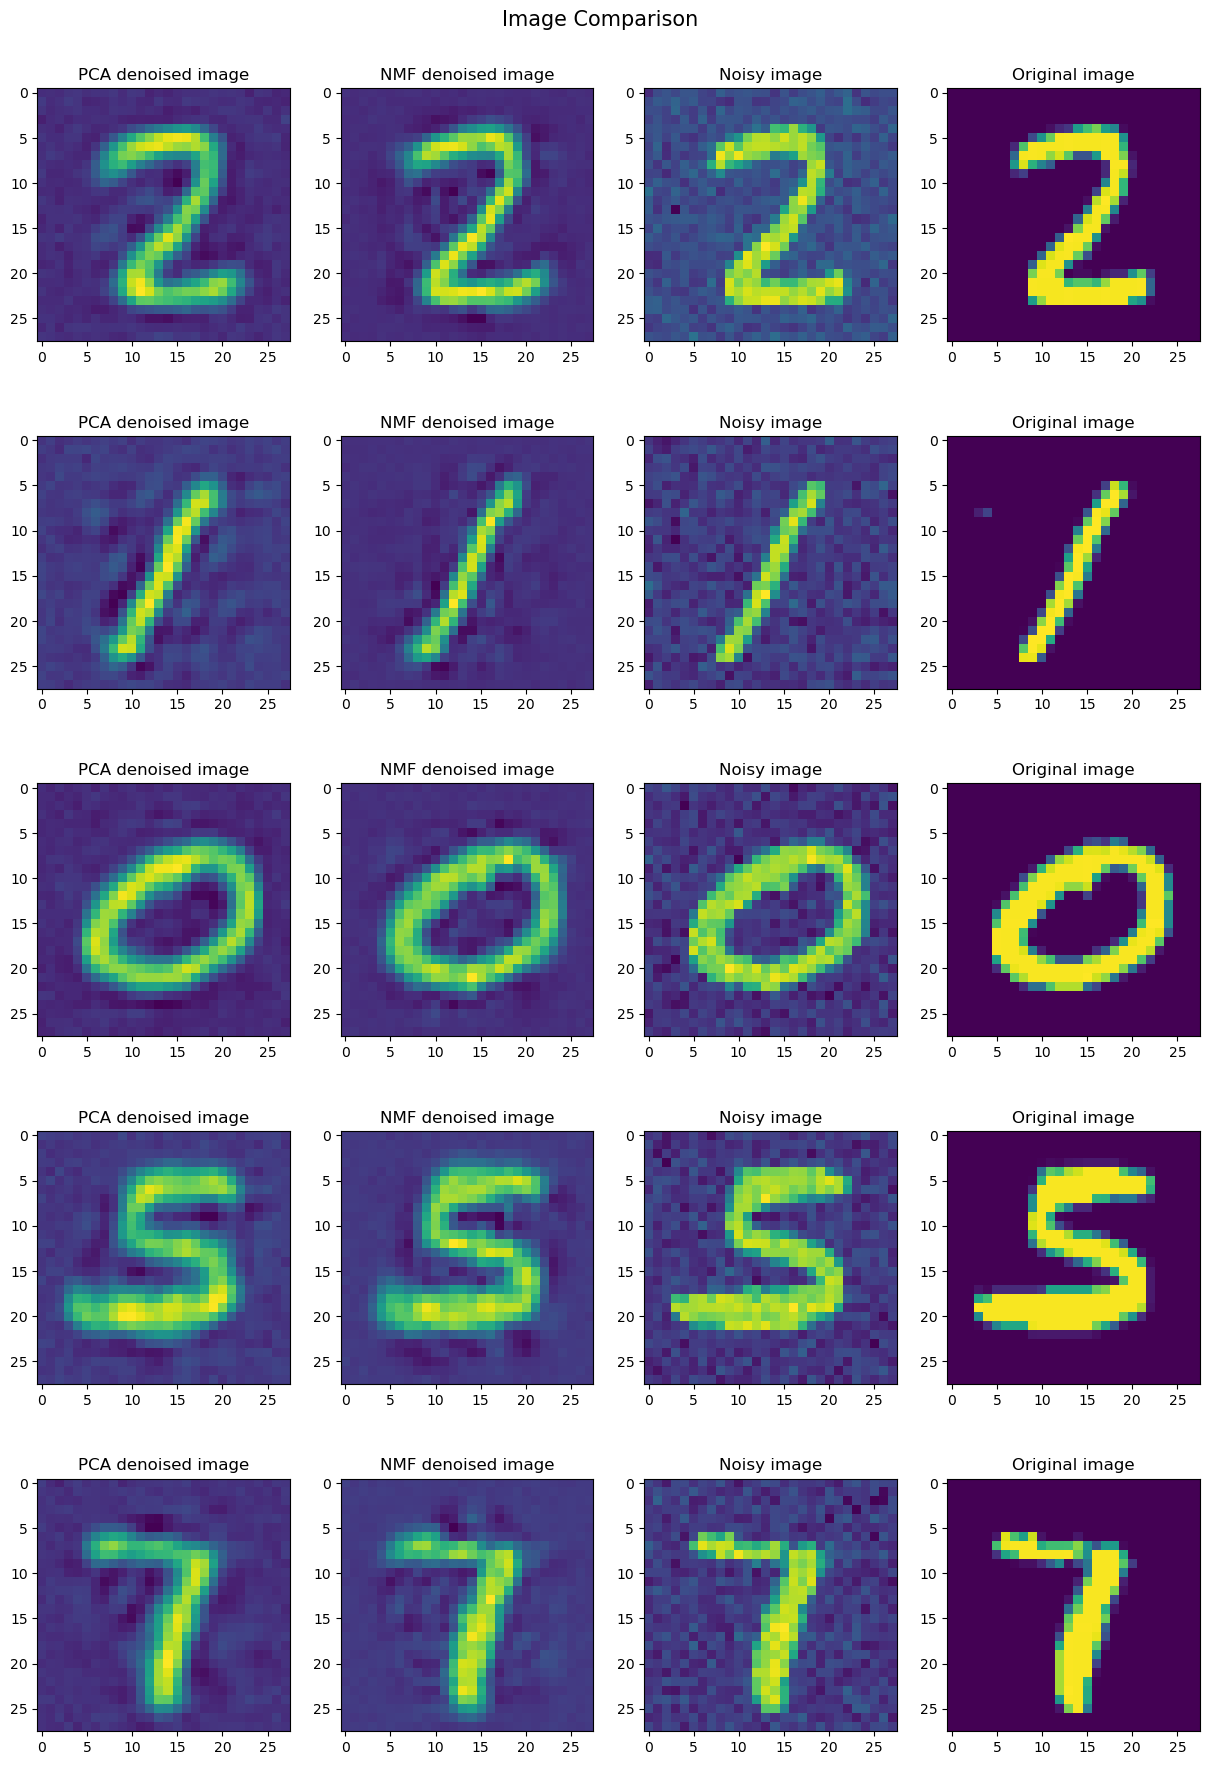

In [52]:
np.random.seed(41)
random_image_indexes = np.random.randint(0, x_test_MNIST_noisy.shape[0], 5)

# create comparison plot
fig, axs = plt.subplots(nrows=len(random_image_indexes), ncols=4,figsize=(15,20))
fig.suptitle("Image Comparison", fontsize=15)
for i, image_idx in enumerate(random_image_indexes):
    axs[i, 0].imshow(x_test_pca_denoised[image_idx].reshape([28,28])) # plot pca denoised image
    axs[i, 0].set_title("PCA denoised image", fontsize=12)
    axs[i, 1].imshow(x_test_nmf_denoised[image_idx].reshape([28,28])) # plot nmf denoised image
    axs[i, 1].set_title("NMF denoised image", fontsize=12)
    axs[i, 2].imshow(x_test_MNIST_noisy[image_idx].reshape([28,28])) # plot noisy image
    axs[i, 2].set_title("Noisy image", fontsize=12)
    axs[i, 3].imshow(x_test_MNIST[image_idx].reshape([28,28])) # plot original image
    axs[i, 3].set_title("Original image", fontsize=12)
plt.subplots_adjust(top=0.95)

We see in our PCA denoised images, it appears that the noisy pixels both inside the digit, and also the background, have been somewhat smoothed out; the denoised image is a lot less grainy than the noisy version, and is closer to the original version in this regard. It has also managed to preserve the contrast between the outline of the digit and the background. The preservation of contrast is likely due to the fact that PCA is focused on preserving the variance in our images, and thus preserving the contrast between pixels. However, we notice that PCA has a more similar appearance in colour to the noisy image, and has not been able to recover as strong of a background colour as there is in the original image. This is a reflection of what we observed when visualizing the PCA components, which appear to have not recognized the distinction of the background colour.

We see in our NMF denoised images the following: whilst it appears to have smoothed out some of the noise in the image, the outline of the coloured digit is a lot less well-defined than in the PCA denoised image, and appears to have a much more noisy intersection with the background. However, away from the digit itself most of the noise in the background has been completely removed during the denoising, more so than in the PCA denoised image.

Overall both methods have done a fairly good job at denoising, and there are arguments for both methods being the best. Denoising using PCA is more suitable in terms of improving the visibility and aesthetics if one was trying to identify the digit from the noisy image, due to the sharper contrast between the digit and the background. However, one could argue that NMF has been able to remove more noise in the background of the image, making it more like the original. It is interesting to observe that despite the differences in the components of PCA and NMF, the denoised images using them look quite similar.

1.2.4

The function `image_MSE()` computes the mean-squared error between the pixels of two images.

In [53]:
def image_MSE(image1, image2):
    """
    Compute the mean squared error between two images.
    Args:
        image1: K x 784 array of the first image.
        image2: K x 784 array of the second image.
    Returns:
        mse: float, the mean squared error between the two images.
    """
    return np.mean(np.square(image1 - image2))

We now use this function to reconstruct the testing images from the noisy images with $m$ principal components for $m \in [5, 400]$, and then for each of these reconstructions compute the MSE between the reconstructions and the original images without noise, and also the MSE between the reconstructions and the noisy images.

In [54]:
# define the range of m
m_range = np.arange(5, 401, 5)
# initialize the MSE dictionaries
noise_denoised_mse_dict = {}
normal_denoised_mse_dict = {}
for m in m_range:
    # denoise using PCA
    x_test_pca_denoised_scaled = denoise_pca(x_train_MNIST_noisy_scaled, x_test_MNIST_noisy_scaled, m)
    # scale back up by 255
    x_test_pca_denoised = x_test_pca_denoised_scaled * 255
    # compute MSEs
    noise_denoised_mse_dict[m] = image_MSE(x_test_pca_denoised, x_test_MNIST_noisy)
    normal_denoised_mse_dict[m] = image_MSE(x_test_pca_denoised, x_test_MNIST)

We plot the MSE's as a function of the number of principal components $m$ below.

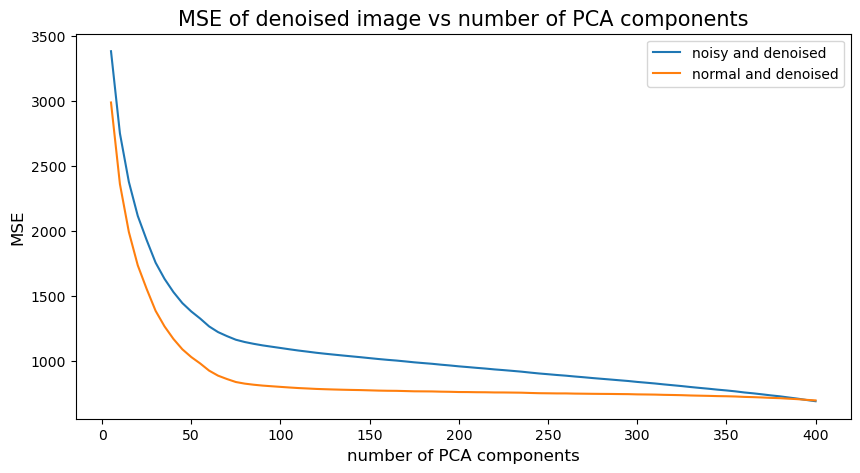

In [55]:
# create MSE plot
plt.figure(figsize=(10,5))
plt.plot(noise_denoised_mse_dict.keys(), noise_denoised_mse_dict.values(), label="noisy and denoised")
plt.plot(normal_denoised_mse_dict.keys(), normal_denoised_mse_dict.values(), label="normal and denoised")
plt.xlabel("number of PCA components", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("MSE of denoised image vs number of PCA components", fontsize=15)
plt.legend()

From our plot we see that both the MSE between the noisy and denoised, and the MSE between the normal and denoised, decrease as we increase the number of PCA components.

We see that the MSE between the normal and denoised images appears to decrease very quickly initially, before appearing to level off after we exceed around 100 principal components of the noisy training images. The initial steepness can be explained by the fact that using more principal components should remove more noise from our noisy testing images, as we capture more information (variance) about the original images from our noisy training images; the first principal components explain the most variance. Removing more noise gives a better reconstruction of the original images without noise, and hence we see the MSE between them decrease. The levelling off/flattening of the curve suggests that adding more principal components beyond a certain point does improve our reconstruction very significantly since later principal components give less information (variance) to train from, and so it may not be possible to remove all the noise in the curve and therefore our MSE stays relatively constant. We see that even if we increase the number of training PCA components past 400, the MSE remains flat and does not reach 0.

On the other hand, the MSE between the noisy and denoised images still decreases quickly initially, before beginning to decrease slower after we exceed around 100 principal components of the noisy training images. We have steepness initially again due to the fact that as well as capturing more variance from the original images, this may also include some of the noise in our noisy training images, and so our MSE decreases as we add more principal components. Although the curve appears to be less steep after around 100 noisy training principal components, there are still significant decreases as we increase the number of principal components, as we learn more noise from the noisy training images; this may be due to the later principal components still containing information about noise, even if the relevant image information is diminished. We see that this trend continues even as we increase the number of PCA components past 400 (see plot below).

We also notice that the two curves intersect when around 400 principal components are used, which is the point at which the denoised image is just as good a representation of the noisy image as it is of the original image in terms of MSE of the pixels. Prior to this, the noisy and denoised curve was always above the original denoised curve, which implies that for less than 400 principal components our denoised image represented the original image more than the noisy image. However, if we continued the curve past 400 principal components we would see the opposite of the curve for the MSE between the denoised and noisy lying below the curve of the MSE between the denoised and original; in this situation the denoised inage is a better representation of the noisy image than the original. This suggests that if we want to denoise our test images effectively, we should select around 100 principal components, just as the denoised and original MSE curve becomes flatter ('elbow'); if we add any more components, we see that we add more noise as the denoised and noisy MSE curve continues to fall, without significantly improving our denoised image much as there is very little decrease in the denoised and original MSE curve.

To illustrate our discussion of the curves past 400 principal components, we plot this extended curve below. Note that this is not the plot asked for in the question (we did that above), but just an extra plot to aid discussion.

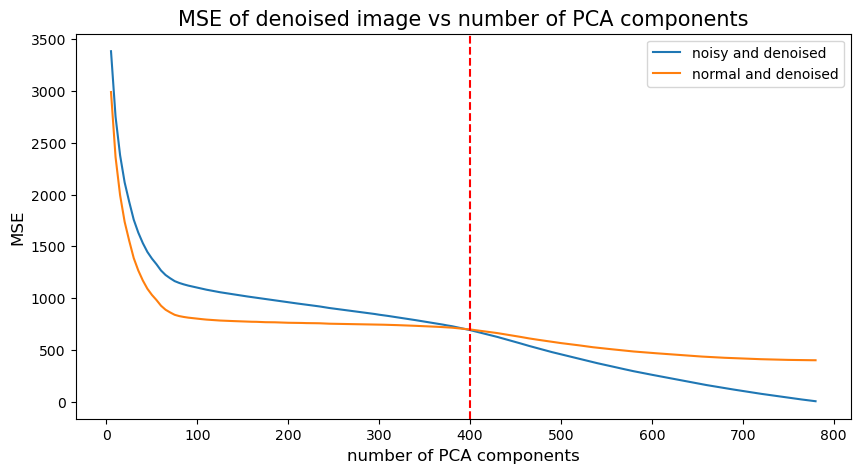

In [56]:
# define the range of m
m_range = np.arange(5, 785, 5)
# initialize the MSE dictionaries
noise_denoised_mse_dict = {}
normal_denoised_mse_dict = {}
for m in m_range:
    # denoise using PCA
    x_test_pca_denoised_scaled = denoise_pca(x_train_MNIST_noisy_scaled, x_test_MNIST_noisy_scaled, m)
    # scale back up by 255
    x_test_pca_denoised = x_test_pca_denoised_scaled * 255
    # compute MSEs
    noise_denoised_mse_dict[m] = image_MSE(x_test_pca_denoised, x_test_MNIST_noisy)
    normal_denoised_mse_dict[m] = image_MSE(x_test_pca_denoised, x_test_MNIST)

# create extra MSE plot for m between 5 and 784
plt.figure(figsize=(10,5))
plt.plot(noise_denoised_mse_dict.keys(), noise_denoised_mse_dict.values(), label="noisy and denoised")
plt.plot(normal_denoised_mse_dict.keys(), normal_denoised_mse_dict.values(), label="normal and denoised")
plt.xlabel("number of PCA components", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("MSE of denoised image vs number of PCA components", fontsize=15)
plt.legend()
plt.axvline(x=400, color="red", linestyle="--")

Let us now visualize a random noisy test image denoised using 10, 40, 100, and 200 noisy training image principal components.

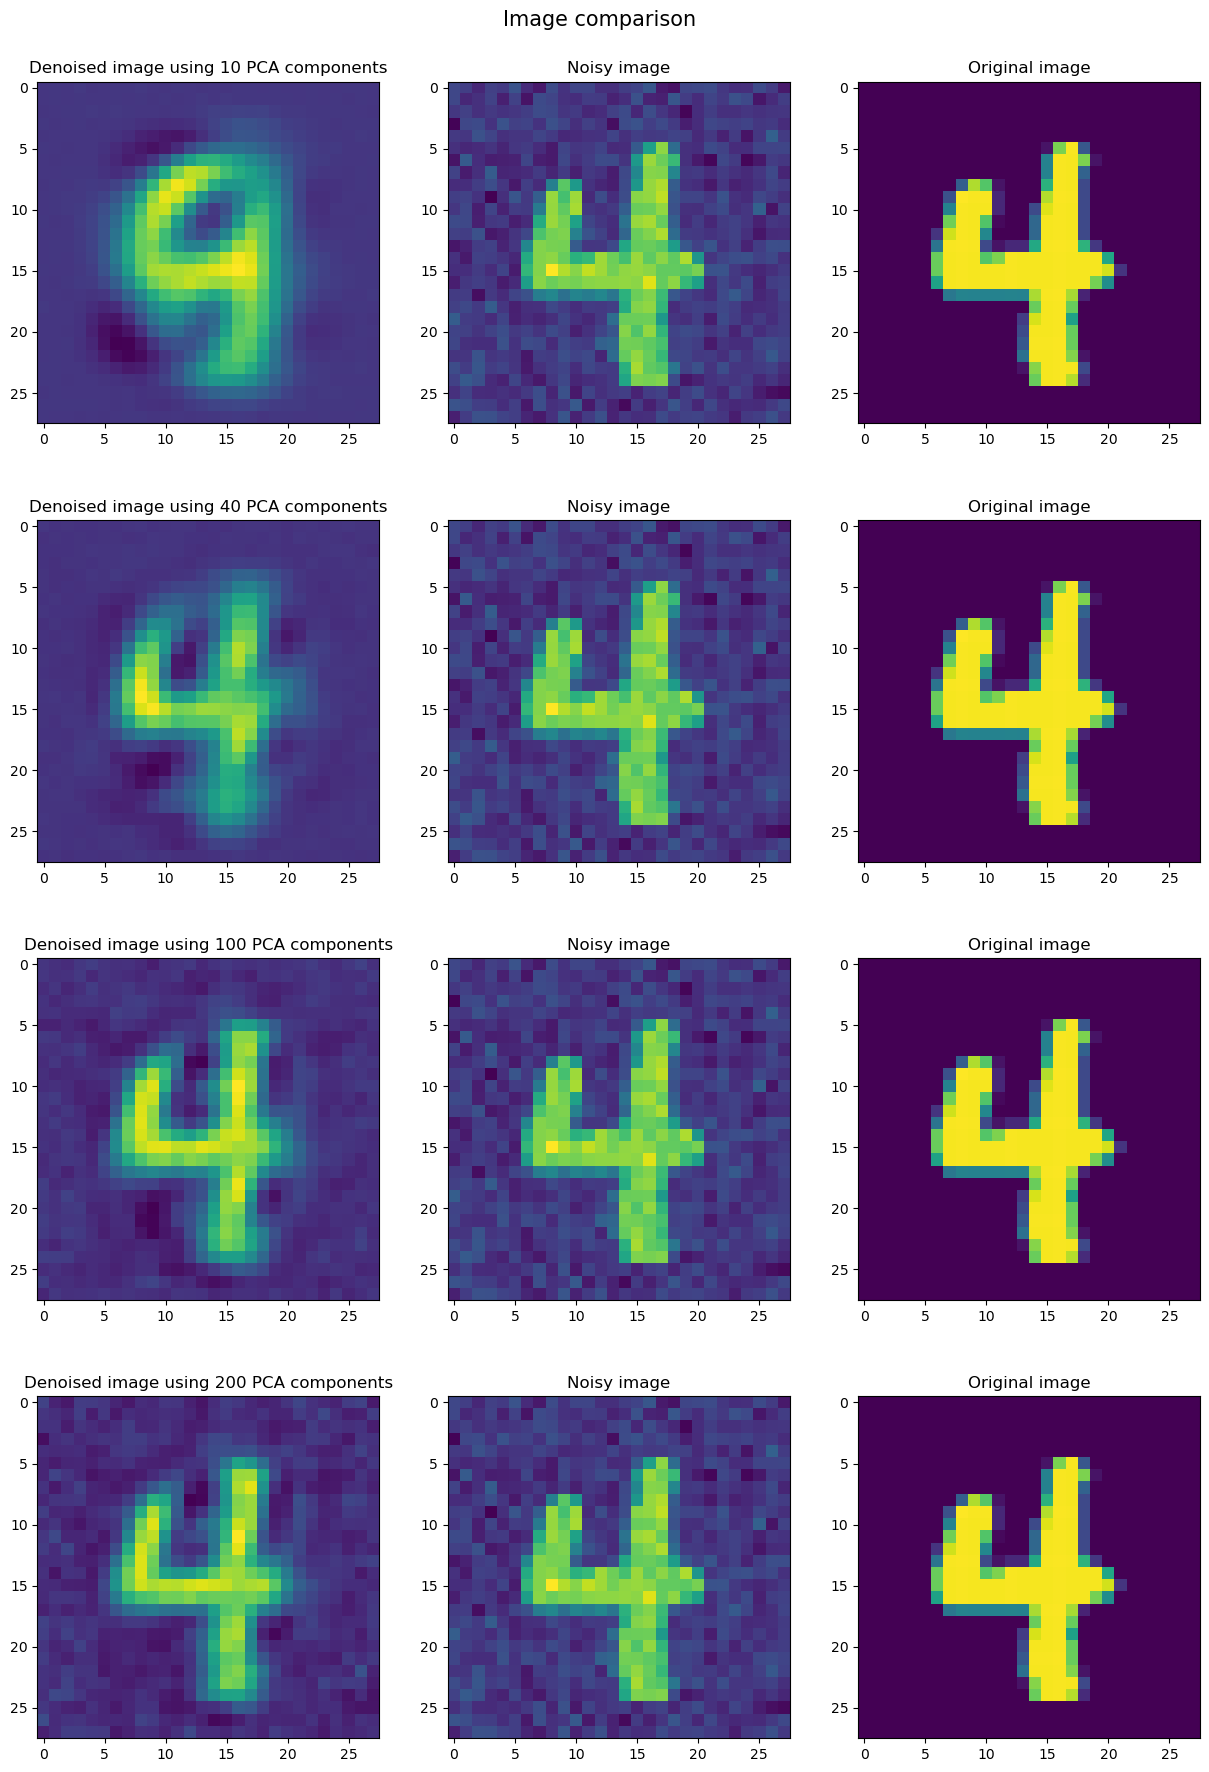

In [57]:
np.random.seed(2)
random_image_index = np.random.randint(0, x_test_MNIST_noisy.shape[0])

# create comparison plot for different number of components
fig, axs = plt.subplots(nrows=4, ncols=3,figsize=(15,20))
fig.suptitle("Image comparison", fontsize=15)
plt.subplots_adjust(top=0.95)
m_list = [10, 40, 100, 200]
for i, m in enumerate(m_list):
    x_test_pca_denoised_scaled = denoise_pca(x_train_MNIST_noisy_scaled, x_test_MNIST_noisy_scaled, m)
    x_test_pca_denoised = x_test_pca_denoised_scaled * 255
    axs[i, 0].imshow(x_test_pca_denoised_scaled[random_image_index].reshape([28,28]))
    axs[i, 0].set_title(f"Denoised image using {m} PCA components", fontsize=12) # plot denoised image
    axs[i, 1].imshow(x_test_MNIST_noisy[random_image_index].reshape([28,28]))
    axs[i, 1].set_title("Noisy image", fontsize=12) # plot noisy image
    axs[i, 2].imshow(x_test_MNIST[random_image_index].reshape([28,28]))
    axs[i, 2].set_title("Original image", fontsize=12) # plot original image

We can see that using more principal components during our denoising appears to give a clearer, sharper reconstruction of the original image, which agrees with the curve we saw in the MSE. However, we also see that the difference between the 100 component reconstruction and the 200 component reconstruction is not very noticable other than that the image with 200 components appears to have extra residual noise, which supports our discussion of the MSE curves in that we begin to pick up extra noise when using more than 100 components, without much improvement in the appearance of the denoised image compared to the original.

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1

We start with the definition of a Gaussian Mixture Model (GMM):
\begin{align}
P(\boldsymbol{X}=\boldsymbol{x}) = \sum_{k=1}^K \pi_k p_k(\boldsymbol{x}|\boldsymbol{\theta})\, .
\end{align}
We have $\boldsymbol x \in \mathbb{R}^n$, and $K$ is the number of clusters described as mixture components, each of which are multivariate normal distributions:
\begin{align}
p_k(\boldsymbol{x}|\boldsymbol{\theta}) = {\displaystyle (2\pi )^{-n/2}\det({\boldsymbol {\Sigma }_k})^{-1/2}\,\exp \left(-{\frac {1}{2}}(\mathbf {x} -{\boldsymbol {\mu }_k})^{\!{\mathsf {T}}}{\boldsymbol {\Sigma }_k}^{-1}(\mathbf {x} -{\boldsymbol {\mu }_k})\right),}
\end{align}
where $\boldsymbol{\theta} = \{\pi_k,\mu_k, \Sigma_k \}_{k=1,2,...,K}$ is the vector of parameters consiting of the mixture weight $\pi_k$, mixture component mean $\boldsymbol{\mu}_k$ and mixture component covariance matrix $\boldsymbol{\mu}_k$.

Below in the `GMModel` class is an implementation of a Gaussian Mixture Model, which can be initialized for a given data set and specifiication of the number of mixture components.

Using our model, we can perform 'soft' clustering of the data by computing the cluster probabilities of the data, given by:
\begin{align}
r_{ik}(\boldsymbol{\theta})=P(Z=k|\boldsymbol{X}=\boldsymbol{x}_i,\boldsymbol{\theta}) = \frac{\pi_k p_k(\boldsymbol{x}_i|\boldsymbol{\theta})}{\sum_{k'=1}^K \pi_{k'} p_{k'}(\boldsymbol{x}_i|\boldsymbol{\theta})},
\end{align}
where $r_{ik}(\boldsymbol{\theta})$ denotes the probability of data point $\boldsymbol x_i$ to belong to cluster $k$, for the model with parameters $\boldsymbol \theta$. This essentially describes a discrete probability distribution of the cluster assignment of each data point.

The `GMModel.cluster_probabilities()` class method has been implemented to calculate these distributions of each data point $\boldsymbol x_i$.

The `GMModel.predict()` class method has been implemented to obtain $k^*$ for each $\boldsymbol x_i$, where cluster $k^*$ is the highest probability cluster assignment for that data point i.e. $k^* = \underset{k}{\mathrm{argmax}}$ $r_{ik}$.

In order to train the parameters of our Gaussian Mixture Model, we employ the EM algorithm. The algorithm iteratively updates parameters of the Gausian Mixture. The algorithm is guaranteed to improve (or at least not worsen) the marginal likelihood of the data. The algorithm updates the mixture weights:
\begin{align}
	\pi_k^{(n+1)} = \frac{1}{N}\sum_{i=1}^N r_{ik}(\boldsymbol{\theta}^{(n)}),
\end{align}
and computes the cluster means using a weighted mean:
\begin{align}
\boldsymbol{\mu}_k^{(n+1)} =\sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(n)}) \boldsymbol{x}_i,
\end{align}
and similarly for the covariances according to:
\begin{align}
\boldsymbol{\Sigma}_k^{(n+1)}= \sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(n)}) (\boldsymbol{x}_i-\boldsymbol{\mu}_k) (\boldsymbol{x}_i-\boldsymbol{\mu}_k)^T.
\end{align}
The weights are obtained from the cluster probabilities via:
\begin{align}
w_{ik}(\boldsymbol{\theta}^{(n)})=\frac{r_{ik}(\boldsymbol{\theta}^{(n)})}{\sum_{i'} r_{i'k}(\boldsymbol{\theta}^{(n)})}.
\end{align}

We implement one iteration of this algorithm in the class method `GMModel.fitStep()`.

In order to know when our EM algorithm has converged, we need to employ some form of convergence criteria. We will use the log-likelihood of our mixture model:
\begin{align}
	l(\boldsymbol \theta^{(n)}) = \sum_i^N \mathrm{log} \left(\sum_{k=1}^K \pi_k p_k(\boldsymbol{x}_i|\boldsymbol{\theta^{(n)}})\right),
\end{align}
where $\theta^{(n)}$ is our parameter set at iteration $k$.
We say our algorithm has converged when the change in consecutive log-likelihoods is less than a specified threshold. In other words $|l(\boldsymbol \theta^{(n+1)}) - l(\boldsymbol \theta^{(n)})| < \mathrm{tolerance}$.

With all these defined, we can perform iterations of the EM algorithm until this difference is less than a given threshold, and we implement this in `GMModel.fit()`, where we obtain the log-likelihood from calling `GMModel.gmm_log_likelihood()`.

In [58]:
class GMModel:
    """
    Class to define a Gaussian Mixture Model.
        :param dim: number of mixture components
        :param weights: mixture weights
        :param phi: mixture component weights
        :param n_samples: number of samples in the dataset
        :param mu: mixture component means for each cluster
        :param sigma: mixture component covariance matrix for each cluster
        :param X: dataset
    """
    def __init__(self, X, dim):
        """
        Initializes parameters through random split of the data.
        Args:
            X: N x D array of data points.
            dim: int, number of mixture components.
        Returns:
            None
        """
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        # initialize n_samples which has the number of rows of dataset X
        self.n_samples = X.shape[0]

        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=self.n_samples, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 

        # initialize dataset X
        self.X = X


    def cluster_probabilities(self):
        """
        Predicts probability of each data point with respect to each cluster.
        Args:
            None
        Returns:
            weights: N x k array of probabilities of each data point with respect to each cluster.
        """

        # Creates a n*k matrix denoting likelihood belonging to each cluster 
        likelihood = np.zeros( (self.n_samples, self.dim) ) 
        for i in range(self.dim):
            # likelihood of data belonging to i-th cluster 
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(self.X)

        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights


    def predict(self):
        """
        Performs hard clustering.
        Args:
            None
        Returns:
            labels: N x 1 array of cluster labels.
        """
        weights = self.cluster_probabilities()
        return np.argmax(weights, axis=1)
    
    
    def fitStep(self):
        """
        Performs an EM step by updating all parameters.
        Args:
            None
        Returns:
            None
        """
        
        # E-Step: update weights and phi holding mu and sigma constant
        weights = self.cluster_probabilities()
        self.phi = weights.mean(axis=0)
            
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.dim):
            weight = weights[:, [i]]
            total_weight = weight.sum()

            self.mu[i] = (self.X * weight).sum(axis=0) / total_weight 
            self.sigma[i] = np.cov(self.X.T,aweights=(weight/total_weight).flatten(), bias=True)


    def gmm_log_likelihood(self):
        """
        Computes the log likelihood of the data under the current model.
        Args:
            None
        Returns:
            gmm_log_likelihood: float, log likelihood of the data under the current model.
        """
        # Creates a n*k matrix denoting likelihood belonging to each cluster 
        likelihood = np.zeros( (self.n_samples, self.dim) )
        for i in range(self.dim):
            # likelihood of data belonging to i-th cluster 
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(self.X)

        weighted_likelihood = likelihood * self.phi
        gmm_log_likelihood = np.log(weighted_likelihood.sum(axis=1)).sum()
        return gmm_log_likelihood
    

    def mixture_component_log_likelihood(self):
        """
        Computes the log likelihood of the data under each mixture component.
        Args:
            None
        Returns:
            mixture_log_likelihood: N x k array of log likelihood of the data under each mixture component.
        """
        # Creates a n*k matrix denoting likelihood of each mixture component
        likelihood = np.zeros( (self.n_samples, self.dim) )
        for i in range(self.dim):
            # likelihood of data belonging to i-th cluster 
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(self.X)
        mixture_log_likelihood = np.log(likelihood)
        return mixture_log_likelihood


    def fit(self, max_its=100, tol=1e-6):
        """
        Performs max_its EM steps with log-likelihood convergence check
        Args:
            max_its: int, maximum number of iterations to run
            tol: float, convergence tolerance
        """
        nth = 0
        for i in range(max_its):
            prev_log_likelihood = self.gmm_log_likelihood()
            self.fitStep()
            new_log_likelihood = self.gmm_log_likelihood()
            if i == 2**nth - 1:
                print("iteration {}, log-likelihood is {}".format(i+1, new_log_likelihood))
                nth += 1
            if np.abs(new_log_likelihood - prev_log_likelihood) < tol:
                print("converged in {} iterations, final log-likelihood is {}".format(i+1, new_log_likelihood))
                break
            if i == max_its-1:
                print("didn't converge in {} iterations".format(max_its))

            
    def plot_2d(self):
        """
        Visualize the space spanned by the first two dimensions of the data.
        """
        ax = plt.gca()
        labels = self.predict()
        s = ax.scatter(self.X[:, 0], self.X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
        ax.axis('equal')
        plt.legend(*s.legend_elements())
        return ax

Now, as requested in the question, we will work with the first 1000 images of the training images, and normalize them so that they are ready to be used for PCA.

In [59]:
# take first 1000 images of the data and normalize
x_train_MNIST_GMM_scaled = x_train_MNIST[:1000] / 255
x_train_MNIST_GMM_norm = normalize_pca(x_train_MNIST_GMM_scaled)[0]

We now take the first 5 principal components.

In [60]:
x_train_MNIST_GMM_norm_pca, x_train_MNIST_GMM_norm_eigvecs, x_train_MNIST_GMM_norm_eigvals = pca(x_train_MNIST_GMM_norm, 5)

We initialize the GMM model with 10 mixture components, and then visualize the space spanned by the top 2 PCA components without any training.

`GMM_plot_2d()` creates the scatter plot seen below, where data points are coloured according to their cluster assignment.

Text(0.5, 1.0, 'Top 2 PCA component space, coloured by cluster assignment in untrained GMM')

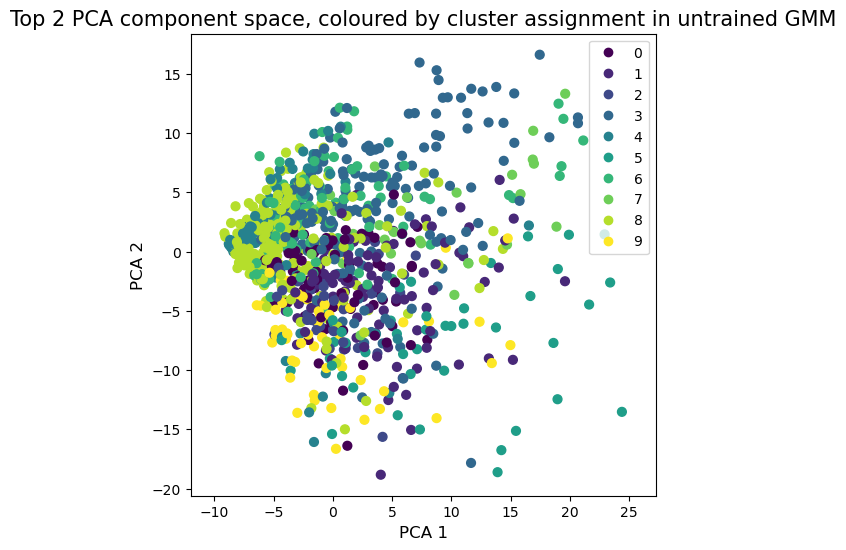

In [61]:
# set seed for reproducibility
np.random.seed(0)
# GMM with 10 components
gmm_10 = GMModel(x_train_MNIST_GMM_norm_pca, 10)

# plot the intial model
plt.figure(figsize=(6, 6))
gmm_10.plot_2d()
plt.xlabel("PCA 1", fontsize=12)
plt.ylabel("PCA 2", fontsize=12)
plt.title("Top 2 PCA component space, coloured by cluster assignment in untrained GMM", fontsize=15)

Let us now train the model parameters using the EM algorithm, with $\mathrm{tolerance} = 10^{-6}$, and visualize the space again once these have been optimized, again colouring the points according to their new cluster assignment.

iteration 1, log-likelihood is -14881.947999175989
iteration 2, log-likelihood is -14631.162985921499
iteration 4, log-likelihood is -14246.190327250497
iteration 8, log-likelihood is -13992.777993325508
iteration 16, log-likelihood is -13898.067503073842
iteration 32, log-likelihood is -13823.762261255835
iteration 64, log-likelihood is -13792.778438843621
iteration 128, log-likelihood is -13785.301467827114
converged in 150 iterations, final log-likelihood is -13785.301366203514


Text(0.5, 1.0, 'Top 2 PCA component space, coloured by cluster assignment in trained GMM')

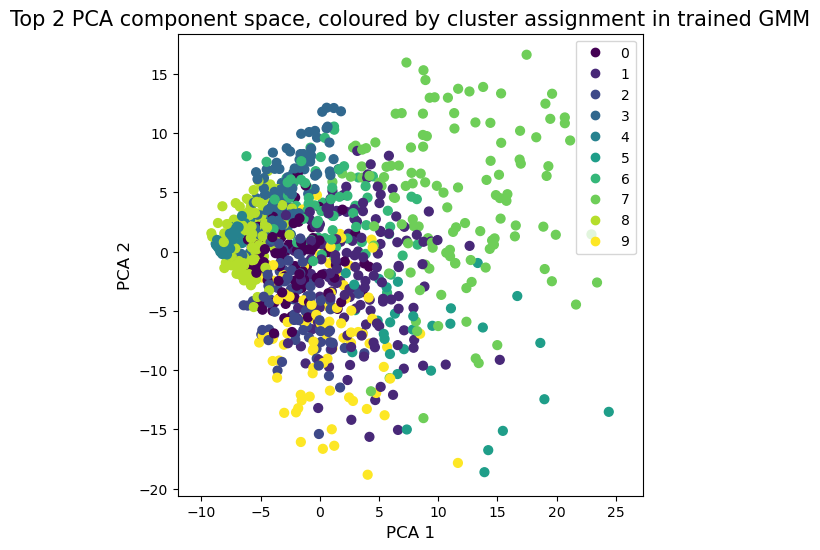

In [62]:
# perform fitting
gmm_10.fit(max_its=1000, tol=1e-6)

# plot the fitted model
plt.figure(figsize = (6,6))
gmm_10.plot_2d()
plt.xlabel("PCA 1", fontsize=12)
plt.ylabel("PCA 2", fontsize=12)
plt.title("Top 2 PCA component space, coloured by cluster assignment in trained GMM", fontsize=15)

We can see the parameter training process has altered the clustering distribution from the random intial cluster assignment into one that appears to be more clustered.

1.3.2

We will now visualize the space spanned by the top two principal components, but this time we colour them according to their true class label.

Text(0.5, 1.0, 'Top 2 PCA component space, coloured by their true class labels')

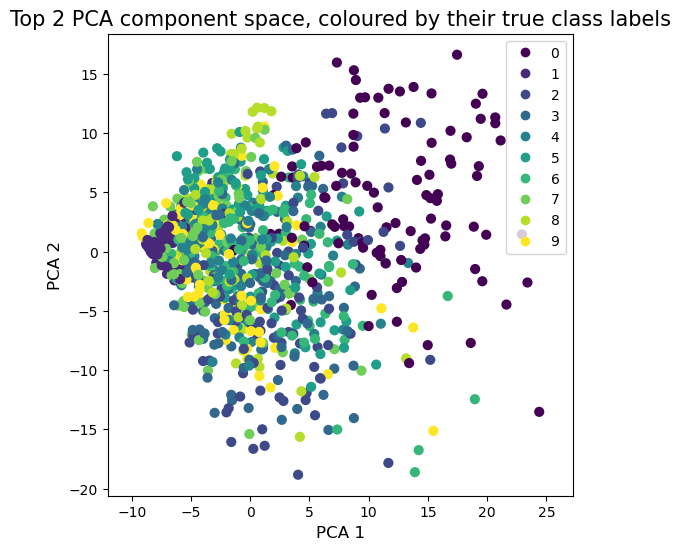

In [63]:
# obtain first 1000 class labels
y_sample = y_train_MNIST[:1000]

# plot
plt.figure(figsize=(6,6))
ax = plt.gca()
# colour by true label
s = ax.scatter(x_train_MNIST_GMM_norm_pca[:, 0], x_train_MNIST_GMM_norm_pca[:, 1], c=y_sample, s=40, cmap='viridis', zorder=2)
ax.axis('equal')
plt.legend(*s.legend_elements())
plt.xlabel("PCA 1", fontsize=12)
plt.ylabel("PCA 2", fontsize=12)
plt.title("Top 2 PCA component space, coloured by their true class labels", fontsize=15)

Now, in order to find the best-fitting cluster index for each class label, we first compute for each datapoint $\boldsymbol x_i$, the quantity $\mathrm{log}\left(p_k(\boldsymbol{x}_i|\boldsymbol{\theta})\right)$ for each cluster $k$; this is the log-likelihood of $\boldsymbol x_i$ belonging to cluster $k$.

Next, we let $\mathcal{L}_j$ be the set where $\boldsymbol x_i \in \mathcal{L}_j$ if $\boldsymbol x_i$ has class label j.

Using this notation, for each class label $j$, we can compute $\underset{k}{\mathrm{argmax}} \sum_{\boldsymbol x_i \in \mathcal{L}_j} \mathrm{log}\left(p_k(\boldsymbol{x}_i|\boldsymbol{\theta})\right)$. This quantity is the cluster index $k$ that gives the highest total log-likelihood over all the data points with true label $j$. We define `label_best_cluster_map()` below to compute this mapping for a given GMM.

In [64]:
def label_best_cluster_map(y, gmm):
    """
    Finds the best-fitting cluster index for each class label,
    based on log-likehood of the data for each cluster.
    Args:
        y: N x 1 array of class labels
        gmm: GMModel object
    Returns:
        label_cluster_map: dict, mapping from class label to best-fitting cluster index
    """
    # get the log-likelihoods
    data_cluster_log_likelihood = gmm.mixture_component_log_likelihood()
    # initialize an intermediate array to store the sum of log-likelihoods for each class label
    label_cluster_log_likelihood = np.zeros((len(np.unique(y)), data_cluster_log_likelihood.shape[1]))
    for label in np.unique(y):
        # get the indexes of the data points with the current label
        data_idxs = np.argwhere(y == label)
        # sum the log-likelihoods of the data points with the current label
        label_cluster_log_likelihood[label] = data_cluster_log_likelihood[data_idxs].sum(axis=0)
    # get the cluster index with the highest log-likelihood for each class label
    label_cluster_mle = np.argmax(label_cluster_log_likelihood, axis=1)
    # create a dictionary mapping from class label to best-fitting cluster index
    label_cluster_map = {label:cluster for label, cluster in zip(np.unique(y), label_cluster_mle)}
    return label_cluster_map

We can compute the best-fitting cluster indexes for each of our class labels.

In [65]:
# get the best-fitting cluster index for each class label for our GMM with 10 components
label_cluster_map_10 = label_best_cluster_map(y_sample, gmm_10)
# construct a dataframe to display the mapping
label_cluster_mle_10_df = pd.DataFrame(label_cluster_map_10.values(), columns=['MLE cluster index'], index=[f"Label {i}" for i in np.unique(y_sample)])
label_cluster_mle_10_df


/var/folders/_4/36mnkhsd5z3405z6q2wmp5000000gn/T/ipykernel_71057/1134086968.py:136: RuntimeWarning: divide by zero encountered in log
  mixture_log_likelihood = np.log(likelihood)


,MLE cluster index
Label 0,7
Label 1,4
Label 2,9
Label 3,1
Label 4,6
Label 5,7
Label 6,1
Label 7,6
Label 8,7
Label 9,2


For the GMM with 10 mixture components we can see that we do not get a 1 to 1 correspondance between the class labels and the best-fitting cluster indexes; we only have six unique cluster indexes, with multiple class labels being mapped to the same cluster index. Labels 0, 5, and 8 are all mapped to the same cluster, 3 and 6 are mapped to the same cluster, and also labels 4, and 7 are all mapped to the same cluster.

1.3.3

For each class label, we now want to visualize the space spanned by the top two principal components, but this time we colour each point according to the cluster probability of the best-fitting cluster. We will utilise our `GMModel.cluster_probabilities()` function to help us do this.

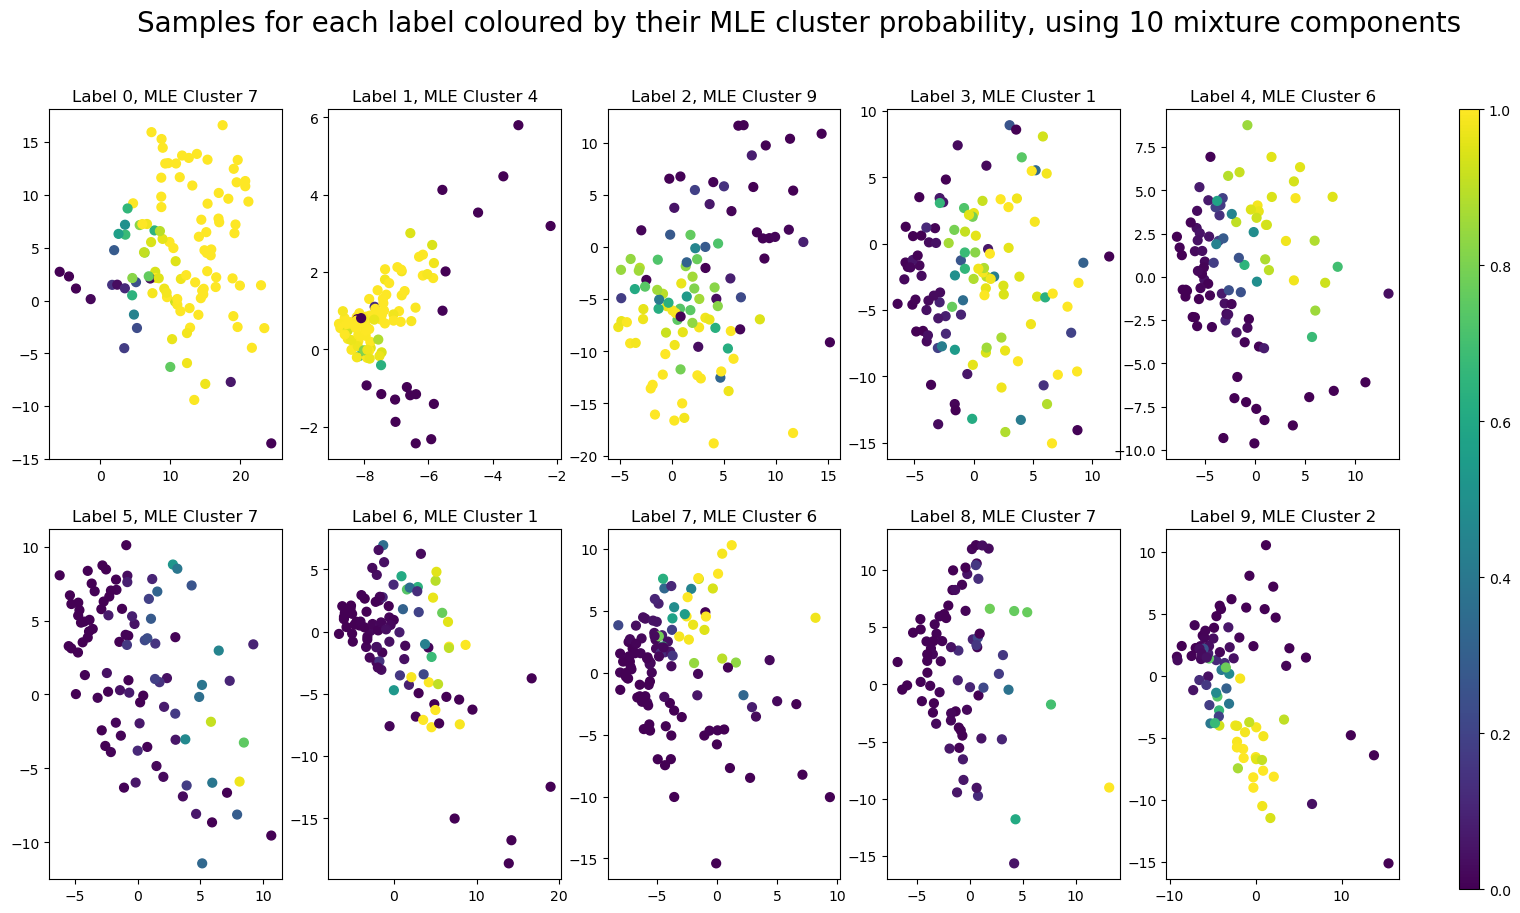

In [66]:
# visualize the MLE cluster probabilities for each label
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
cluster_probs_10 = gmm_10.cluster_probabilities()
for label, ax in zip(np.unique(y_sample), axs.reshape(-1)):
    ax.set_title(f"Label {label}, MLE Cluster {label_cluster_map_10[label]}")
    # get indexes of data points for this label
    data_label_idxs = np.argwhere(y_sample == label)
    # get the MLE cluster probabilities for this each data point with this label
    data_cluster_probs = cluster_probs_10[data_label_idxs, label_cluster_map_10[label]].reshape(-1)
    # plot the data points with the MLE cluster probabilities as the colour
    im = ax.scatter(x_train_MNIST_GMM_norm_pca[data_label_idxs, 0], x_train_MNIST_GMM_norm_pca[data_label_idxs, 1], c=data_cluster_probs, s=40, cmap='viridis', zorder=2, vmin=0, vmax=1)
fig.suptitle("Samples for each label coloured by their MLE cluster probability, using 10 mixture components", fontsize= 20)
fig.subplots_adjust(right=0.8)
cb_ax = fig.add_axes([0.83, 0.1, 0.01, 0.78])
cbar = fig.colorbar(im, cax=cb_ax)

From the above plot for a GMM with 10 mixture components, we see that other than the plots for class label 0 and 1, which have many lighter/yellow points (points with a probabilitiy of belonging to the best-fitting cluster close to 1), the plots for the other labels have mostly darker/purple points (points with a probability of the belonging to the best-fitting close to 0). This high proportion of low probability points suggests that our best-fitting cluster assignment may not be the best clustering of the data. We will now discuss potential reasons as to why we might have this uncertainty in our clustering.

One key reason for this lack of optimality in our cluster assignment could be that the optimisation of the GMM parameters using the EM algorithm is not a convex optimisation problem; our convergence is guaranteed to a local minima, but it may not be a global minima. It is likely that there are multiple minima, and so we may not have found the true global optimum of paramters through our algorithm, and thus also not found the optimal clustering. We could try and mitigate this issue by running the algorithm repeatedly with multiple random initializations, and hopefully we will get closer to the true optimal paramters and therefore true optimal clustering.

Another possibility for uncertainty is the assignment of the best-fitting cluster itself using the log-likelihoods of the points. First, due to the fact that we use the log-likelihoods, our assignment can be heavily affected by outliers (unusual digit representations in this context), as if there is even one such point with very small likelihood of belonging for a certain cluster, the log-likelihood is going to be very negative. This means that even if all the other points have very high likelihood, it is unlikely to be classfied as the best-fitting cluster because of this outlier.

Furthermore, we can see from our plot where points are coloured by class label that it is quite hard to see any clear clustering/distinction between the classes, and so this may make it more difficult to successfully assign them to the correct clusters in our GMM as their corresponding distributions may overlap.

1.3.4

We now repeat the above process of finding the best-fitting cluster mapping using log-likelihood, but this time using 8 mixture components in our GMM. We optimize the model parameters first, again using $\mathrm{tolerance}=10^{-6}$.

In [67]:
# set seed for reproducibility
np.random.seed(6)
# GMM with 10 components
gmm_8 = GMModel(x_train_MNIST_GMM_norm_pca, 8)
# perform fitting
gmm_8.fit(max_its=1000, tol=1e-6)

iteration 1, log-likelihood is -14863.600705038001
iteration 2, log-likelihood is -14664.719767701583
iteration 4, log-likelihood is -14467.726521344759
iteration 8, log-likelihood is -14148.383589131634
iteration 16, log-likelihood is -14023.609555579322
iteration 32, log-likelihood is -13923.508675818926
iteration 64, log-likelihood is -13893.409218611927
iteration 128, log-likelihood is -13874.294196833067
iteration 256, log-likelihood is -13874.240801441214
converged in 452 iterations, final log-likelihood is -13872.807490917468


Let us compute this best-cluster mapping.

In [68]:
# create mapping in table for 8 mixture components
label_cluster_map_8 = label_best_cluster_map(y_sample, gmm_8)
label_cluster_mle_8_df = pd.DataFrame(label_cluster_map_8.values(), columns=['MLE cluster index'], index=[f"Label {i}" for i in np.unique(y_sample)])
label_cluster_mle_8_df

/var/folders/_4/36mnkhsd5z3405z6q2wmp5000000gn/T/ipykernel_71057/1134086968.py:136: RuntimeWarning: divide by zero encountered in log
  mixture_log_likelihood = np.log(likelihood)


,MLE cluster index
Label 0,0
Label 1,2
Label 2,4
Label 3,3
Label 4,7
Label 5,3
Label 6,4
Label 7,7
Label 8,3
Label 9,7


When we reduce our GMM to 8 mixture components, clearly it is not possible to get a one-to-one mapping anymore since we have less mixture components than class labels, and we end up getting five unique best-fitting clusters. We can see that many of labels mapped to the same best-cluster index in the 10 mixture component mapping, such as labels 5 and 8 and labels 4 and 7, continue to be mapped to the same cluster in our 8 mixture component mapping.

We again visualize the cluster probabilities of the best-fitting clusters for the 8 mixture component GMM.

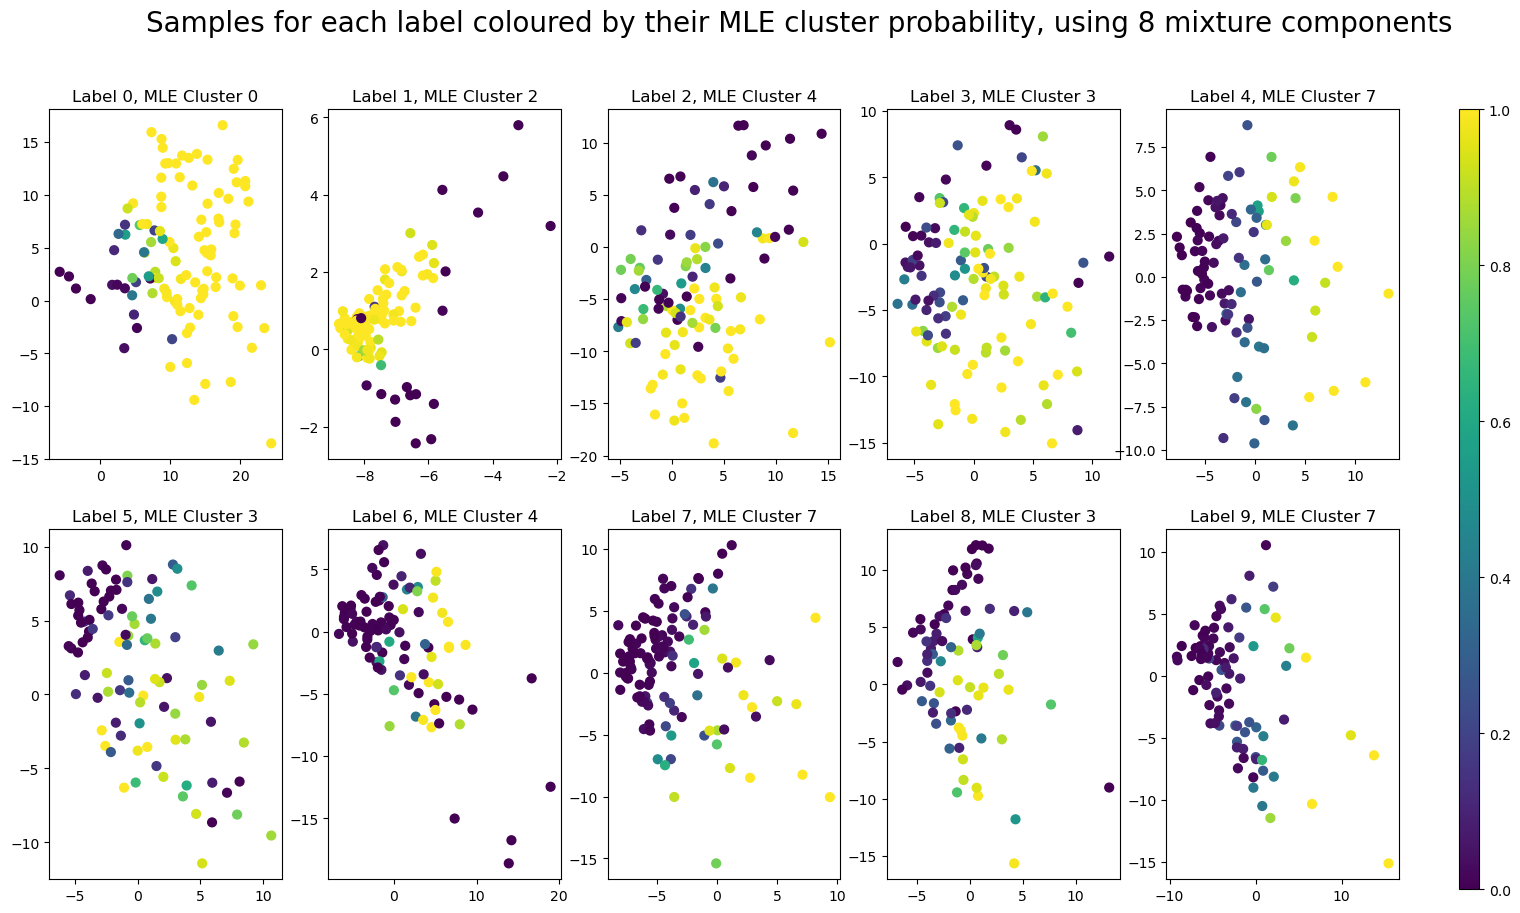

In [69]:
# visualize the MLE cluster assignments for each label
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
cluster_probs_8 = gmm_8.cluster_probabilities()
for label, ax in zip(np.unique(y_sample), axs.reshape(-1)):
    ax.set_title(f"Label {label}, MLE Cluster {label_cluster_map_8[label]}")
    # get indexes of data points for this label
    data_label_idxs = np.argwhere(y_sample == label)
    # get the MLE cluster probabilities for this each data point with this label
    data_cluster_probs = cluster_probs_8[data_label_idxs, label_cluster_map_8[label]].reshape(-1)
    # plot the data points with the MLE cluster probabilities as the colour
    im = ax.scatter(x_train_MNIST_GMM_norm_pca[data_label_idxs, 0], x_train_MNIST_GMM_norm_pca[data_label_idxs, 1], c=data_cluster_probs, s=40, cmap='viridis', zorder=2, vmin=0, vmax=1)
fig.suptitle("Samples for each label coloured by their MLE cluster probability, using 8 mixture components", fontsize= 20)
fig.subplots_adjust(right=0.8)
cb_ax = fig.add_axes([0.83, 0.1, 0.01, 0.78])
cbar = fig.colorbar(im, cax=cb_ax)

Using 8 mixture components appears to have improved the number of high best-fitting cluster probability points for many of the labels compared to the 10 mixture component GMM, as we see more lighter/yellow points than before. This suggests that reducing the number of mixture components from 10 to 8 appears to have reduced some of the uncertainty in our clustering.

We now reduce the number of GMM mixture components further to 5, and repeat the optimization of the GMM with $\mathrm{tolerance}=10^{-6}$.

In [70]:
# set seed for reproducibility
np.random.seed(1)
# GMM with 5 components
gmm_5 = GMModel(x_train_MNIST_GMM_norm_pca, 5)
# perform fitting
gmm_5.fit(max_its=1000, tol=1e-6)

iteration 1, log-likelihood is -14969.593502320653
iteration 2, log-likelihood is -14842.824998882712
iteration 4, log-likelihood is -14649.730942855182
iteration 8, log-likelihood is -14437.491405160465
iteration 16, log-likelihood is -14361.048526949387
iteration 32, log-likelihood is -14350.531307485078
iteration 64, log-likelihood is -14339.239158146616
iteration 128, log-likelihood is -14338.396354409717
converged in 196 iterations, final log-likelihood is -14338.380363624168


Let us now find the best-fitting cluster map for the 5 mixture component GMM.

In [71]:
# create mapping in table for 5 mixture components
label_cluster_map_5 = label_best_cluster_map(y_sample, gmm_5)
label_cluster_mle_5_df = pd.DataFrame(label_cluster_map_5.values(), columns=['MLE cluster index'], index=[f"Label {i}" for i in np.unique(y_sample)])
label_cluster_mle_5_df

/var/folders/_4/36mnkhsd5z3405z6q2wmp5000000gn/T/ipykernel_71057/1134086968.py:136: RuntimeWarning: divide by zero encountered in log
  mixture_log_likelihood = np.log(likelihood)


,MLE cluster index
Label 0,4
Label 1,2
Label 2,1
Label 3,3
Label 4,3
Label 5,3
Label 6,1
Label 7,3
Label 8,4
Label 9,3


When we reduce our GMM to just 5 mixture components, this time we get only four unique best-fitting clusters. In this mapping we see that labels 3, 4, 5, 7, and 9 are all mapped to the same cluster, which may be because there are so few mixture component (clusters) to assign to now in our 5 mixture component GMM.

Let us visualize the best-fitting cluster probabilities to see how they are affected.

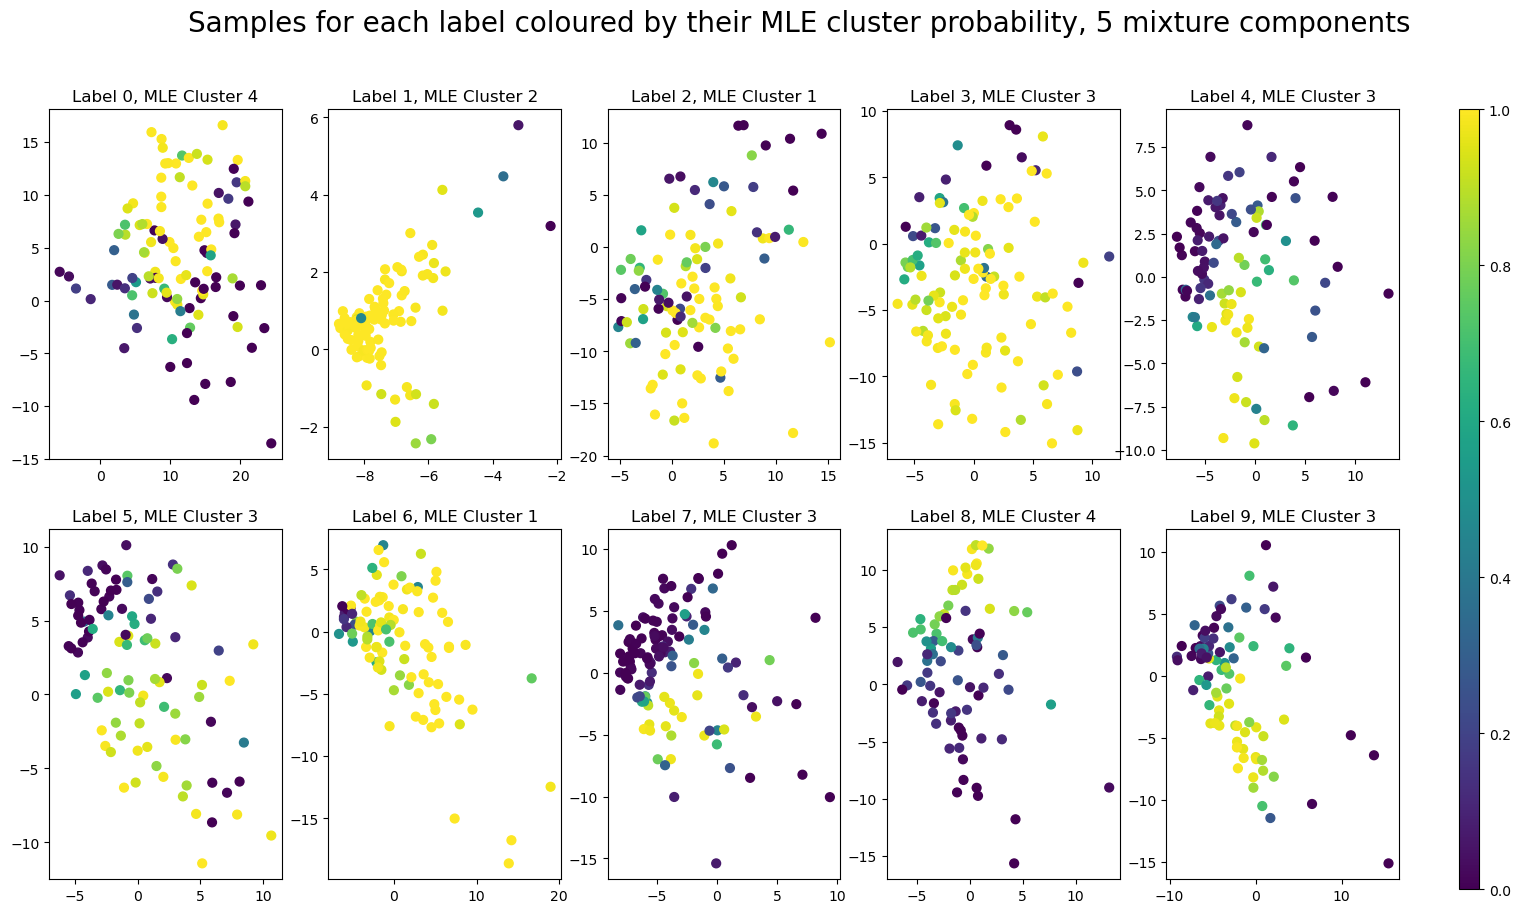

In [72]:
# visualize the MLE cluster assignments for each label
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
cluster_probs_5 = gmm_5.cluster_probabilities()
for label, ax in zip(np.unique(y_sample), axs.reshape(-1)):
    ax.set_title(f"Label {label}, MLE Cluster {label_cluster_map_5[label]}")
    # get indexes of data points for this label
    data_label_idxs = np.argwhere(y_sample == label)
    # get the MLE cluster probabilities for this each data point with this label
    data_cluster_probs = cluster_probs_5[data_label_idxs, label_cluster_map_5[label]].reshape(-1)
    # plot the data points with the MLE cluster probabilities as the colour
    im = ax.scatter(x_train_MNIST_GMM_norm_pca[data_label_idxs, 0], x_train_MNIST_GMM_norm_pca[data_label_idxs, 1], c=data_cluster_probs, s=40, cmap='viridis', zorder=2, vmin=0, vmax=1)
fig.suptitle("Samples for each label coloured by their MLE cluster probability, 5 mixture components", fontsize= 20)
fig.subplots_adjust(right=0.8)
cb_ax = fig.add_axes([0.83, 0.1, 0.01, 0.78])
cbar = fig.colorbar(im, cax=cb_ax)

Using 5 mixture components appears to have improved the number of high best-fitting cluster probability points for many of the labels compared to the 10 mixture component GMM, as we see a lot more lighter/yellow points than before. It also appears to have improved on the 8 mixture component GMM, and we see particular improvement in the number of high best-fitting cluster probability points on labels 1 and 6.


The trend appears to be that decreasing the number of mixture components increases the number of lighter/yellow points (high best-fitting cluster probability points) in our best-fitting cluster assignment. However, whilst one might think that this means we should just use less mixture components (less clusters), this may be a false indication of 'goodness' of our clustering fit; reducing the number of mixture components is likely to increase the probability of the best-fitting cluster assignment, since there are now fewer clusters to choose from. Furthermore, we know in reality we have 10 different digits, so ideally we would like to achieve 10 unique best-fitting clusters with a one-to-one mapping. Our reduced number of clusters is just grouping more and more of these labels together and treating them as one group, which is not very useful.

We combine all the best-fitting cluster maps into a combined table below.

In [73]:
# combine all cluster maps into a comparison table
label_cluster_map_combined_array = np.hstack((np.array([*label_cluster_map_10.values()]).reshape(-1,1), np.array([*label_cluster_map_8.values()]).reshape(-1,1), np.array([*label_cluster_map_5.values()]).reshape(-1,1)))
label_cluster_map_combined_df = pd.DataFrame(label_cluster_map_combined_array, columns = ['10 component MLE cluster index', '8 component MLE cluster index', '5 component MLE cluster index'], index=[f"Label {i}" for i in np.unique(y_sample)])
label_cluster_map_combined_df

,10 component MLE cluster index,8 component MLE cluster index,5 component MLE cluster index
Label 0,7,0,4
Label 1,4,2,2
Label 2,9,4,1
Label 3,1,3,3
Label 4,6,7,3
Label 5,7,3,3
Label 6,1,4,1
Label 7,6,7,3
Label 8,7,3,4
Label 9,2,7,3


As we discussed above in our cluster probability analysis, reducing the number of mixture components appears to reduce the precision of our best-fitting cluster indexes; the number of unique cluster indexes decreases and more labels begin to be mapped to the same cluster. What perhaps is interesting, is that some labels such as 4 and 7 are repeatedly mapped to the same cluster; in terms of the digit pixels, it is possible that they have many in common based on their appearance. This may be why the GMM groups these labels together, as they have some similarity to eachother and thus are being treated as coming from the same distribution.

### Task 2: Clustering and graph-based analysis (35 marks)

#### 2.1 Clustering (15 marks)
2.1.1

Our next task involves a dataset containing gene expression levels.

We will begin by importing the dataset.

In [74]:
# read in the data
gene_expression_data = pd.read_csv("./gene_expression_data.csv")

# check tails
gene_expression_data.tail()

,Gene 0,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,...,Gene 86,Gene 87,Gene 88,Gene 89,Gene 90,Gene 91,Gene 92,Gene 93,Gene 94,Type
795,7.470358,0.000000,0.0,0.759497,12.907773,14.055342,6.352628,7.591919,11.388588,11.528142,...,0.000000,0.000000,11.572307,13.265769,9.496432,5.945493,0.000000,10.922889,1.450063,LUAD
796,6.283574,0.000000,0.0,0.865919,12.353014,13.944694,6.553660,5.665609,8.913329,8.704495,...,0.000000,0.865919,11.375458,13.312075,7.116490,6.105469,0.000000,8.069933,0.000000,BRCA
797,8.113409,0.000000,0.0,0.000000,11.496739,13.107654,8.662768,7.926272,10.260531,10.548620,...,0.000000,1.380896,12.404003,14.256452,7.531046,8.541708,0.000000,7.963838,12.987499,LUAD
798,7.439839,1.002595,0.0,0.000000,11.119304,12.694582,10.221986,9.822217,10.339505,10.202454,...,0.586693,0.586693,11.445589,13.392961,10.384071,10.799249,4.049317,12.538691,11.204602,COAD
799,9.770383,0.000000,0.0,0.000000,10.128291,11.743454,5.575811,5.078392,10.320451,10.385118,...,5.968082,8.056779,12.199040,14.220257,7.046011,5.759009,0.000000,8.240982,13.105047,PRAD


We will extract the 800x95 matrix of different gene expression levels for each of our tumour samples, since the goal of our clustering is to identify groups of samples with similar gene expression patterns. Since it is not required, we shall remove the tumour classification "Type" column.

In [75]:
# extract the 800x95 matrix of gene expression levels
gene_expression_matrix = gene_expression_data[gene_expression_data.columns.drop("Type")]

# convert to numpy
gene_expression_matrix = gene_expression_matrix.to_numpy()

In [76]:
# check we have the right shape
gene_expression_matrix.shape

(800, 95)

$k$-means is a distance-based algorithm, so it is sensible to standardise our gene expression data so that each gene feature is on the same scale.

Our $k$-means algorithm assigns the initial cluster assignments randomly, so it is not necessary to shuffle the gene expression data.

In [77]:
gene_expression_matrix_std = (gene_expression_matrix - np.mean(gene_expression_matrix, axis=0))/np.std(gene_expression_matrix, axis=0)

The clustering algorithm we will perform on our data is the $k$-means algorithm, which involves finding a hard assignment between the $N$ samples and $k$ clusters. It proceeds in the following steps:

1. Assign every sample to one of the $k$ clusters at random.
2. Compute the centroid of each of the cluster $\boldsymbol m_l = \frac{1}{|c_l|}\sum_{i \in c_l}\boldsymbol x^{(i)}, \quad l=1,\dots,k$.
3. For each data point $\boldsymbol x^{(i)}$, reassign it to the cluster with the closest centroid.
4. Iterate steps 2 and 3 until we have convergence.

We will judge our algorithm as converged when the labels remain unchanged from one iteration to the next. It is implemented below in `k_means()`.

In [78]:
def k_means(X, k, max_iter=1000, print_its=True):
    """
    Computes the clustering of the data X using the k-means algorithm.
    Args:
        X: n_samples x n_features numpy array of data.
        k: number of clusters to assign the data to.
        max_iter: maximum number of iterations to perform
        print_its: boolean to determine whether to print iterations and scores
    """

    n_samples, n_features = X.shape

    # labels: assign every sample to a cluster at random
    labels = np.arange(0, k) # ensure there are no empty clusters
    labels = np.append(labels, np.random.randint(low=0, high=k, size=n_samples-k)) # randomly sample remaining
    labels = np.random.permutation(labels) # permute labels
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]

    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        if print_its:
            print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            if print_its:
                print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            if print_its:
                print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    return labels, centroids

As requested, we will code a function to compute the Calinski-Harabasz index of a given clustering. The definition of the Calinski-Harabasz index (CH) is as follows [5]:
\begin{align}
CH_k = \frac{BCSM}{k-1}\cdot\frac{n-k}{WCSM} = \frac{\overbrace{\sum_i^k n_i \cdot d(z_i, z_{tot})^2}^{BCSM}}{k-1}\cdot \frac{n-k}{\underbrace{\sum_{i=1}^k \sum_{x\in c_i} d(x, z_i)^2}_{WCSM}},
\end{align}
where $n$ is the total number of points, $k$ is the number of clusters, $z_i$ is the center of cluster $c_i$, $z_{tot}$ is the center over all of the clusters, and $n_i = |c_i|$.

A higher Calinski-Harabasz index is supposed to indicate a better clustering assignment.

This formula is implemented below in `calinski_harabasz()`.

In [79]:
def calinski_harabasz(X, k, labels, centroids):
    """
    Calculate the Calinski-Harabasz index for a given clustering.
    Args:
        X: n_samples x n_features numpy array of data.
        k: number of clusters.
        labels: n_samples numpy array of cluster labels.
        centroids: k x n_features numpy array of cluster centroids.
    Returns:
        ch_index: the Calinski-Harabasz index.
    """
    n, _ = X.shape
    # calculate the array of z_tot
    z_tot = np.mean(X, axis=0).reshape(1, -1)
    # calculate the size of each cluster
    cluster_sizes = np.array([(labels==i).sum() for i in range(k)])
    # calculate the BCSM and WCSM
    BCSM = (cluster_sizes * (np.square(np.linalg.norm(centroids-z_tot, axis=1)))).sum()
    WCSM = np.square(np.array([[np.linalg.norm(X[idx] - centroids[value]) for idx, value in enumerate(labels)]])).sum()
    # calculate the Calinski-Harabasz index
    ch_index = (BCSM / (k-1)) * ((n-k) / WCSM)
    return ch_index

Now, we can use our functions to determine what the optimal $k$ is to use for clustering. We find this by running $k$-means for each $k$ with 5 different initialisations, and then calculating the average of the Calinski-Harabasz indexes of the corresponding 5 clusterings. Below the funciton `optimize_k_ch()` does this for a given range of $k$'s, and stores the average Calinski-Harabasz index in a dictionary mapping.

In [80]:
def optimize_k_ch(X, k_range):
    """
    Find the average Calinski-Harabasz index over 5 different initializations for each k in k_range.
    Args:
        X: n_samples x n_features numpy array of data.
        k_range: range of k values to test.
    Returns:
        k_scores: dictionary of k values and their corresponding average Calinski-Harabasz index.
    """
    # initialize dict
    k_scores = {}
    for k in k_range:
        scores = []
        # run k-means 5 times to get 5 different intializations
        for i in range(5):
            labels, centroids = k_means(X, k, print_its=False)
            # append scores
            scores.append(calinski_harabasz(X, k, labels, centroids))
        # add average score to dict
        k_scores[k] = sum(scores)/len(scores)
        print(f"k={k}, average Calinski-Harabasz index: {k_scores[k]}")
    return k_scores

Let us call this function on our gene expression data for $k \in [2, 50]$. Note we have chosen this range as we observe very low average Calinski-Harabasz index values outside this range, and it is sufficiently large enough to illustrate the effect of $k$ on clustering with respect to Calinski-Harabasz index. We also do not take $k=1$ in order to prevent division by zero when computing the Calinski-Harabasz index.

Note we only print the average value for each $k$, and not for every iteration of $k$-means performed, as this caused a huge printing log (HTML would not upload).

In [81]:
np.random.seed(69)
k_ch_score_dict = optimize_k_ch(gene_expression_matrix_std, np.arange(2, 51))

k=2, average Calinski-Harabasz index: 200.50146672001807
k=3, average Calinski-Harabasz index: 232.4430016452543
k=4, average Calinski-Harabasz index: 233.13986482851107
k=5, average Calinski-Harabasz index: 199.18545765348532
k=6, average Calinski-Harabasz index: 181.60319250857523
k=7, average Calinski-Harabasz index: 161.3984636869389
k=8, average Calinski-Harabasz index: 145.50377094568722
k=9, average Calinski-Harabasz index: 134.68720194399387
k=10, average Calinski-Harabasz index: 131.42928364913126
k=11, average Calinski-Harabasz index: 123.65590297911282
k=12, average Calinski-Harabasz index: 119.73786025869276
k=13, average Calinski-Harabasz index: 114.39753995800524
k=14, average Calinski-Harabasz index: 103.36250293247483
k=15, average Calinski-Harabasz index: 105.72063256756614
k=16, average Calinski-Harabasz index: 103.70403367694487
k=17, average Calinski-Harabasz index: 97.78734209972865
k=18, average Calinski-Harabasz index: 91.85859650833387
k=19, average Calinski-Har

Let us find the optimal $k$, which is the one that has the highest corresponding average Calinski-Harabasz score.

In [82]:
optimal_k_ch = max(k_ch_score_dict, key=k_ch_score_dict.get)
print(f"optimal k: {optimal_k_ch}")

optimal k: 4


Let us now perform $k$-means again, this time using the optimal $k$ as the number of clusters.

In [83]:
np.random.seed(69)
optimal_clusters_ch = k_means(gene_expression_matrix_std, optimal_k_ch)[0]

Iteration: 0
69.750000% labels changed
Iteration: 1
17.625000% labels changed
Iteration: 2
9.375000% labels changed
Iteration: 3
6.625000% labels changed
Iteration: 4
5.125000% labels changed
Iteration: 5
6.500000% labels changed
Iteration: 6
9.625000% labels changed
Iteration: 7
9.625000% labels changed
Iteration: 8
6.375000% labels changed
Iteration: 9
2.250000% labels changed
Iteration: 10
0.875000% labels changed
Iteration: 11
0.625000% labels changed
Iteration: 12
0.875000% labels changed
Iteration: 13
0.750000% labels changed
Iteration: 14
1.000000% labels changed
Iteration: 15
0.500000% labels changed
Iteration: 16
0.250000% labels changed
Iteration: 17
Labels unchanged! Terminating k-means.


We now calculate the size of each of the clusters of the cluster assignment using the optimal $k$.

In [84]:
print(f"Size of each cluster: {[np.sum(optimal_clusters_ch==cluster) for cluster in np.unique(optimal_clusters_ch)]}")

Size of each cluster: [141, 138, 175, 346]


Finally, we plot the average Calinski-Harabasz index as a function of $k$.

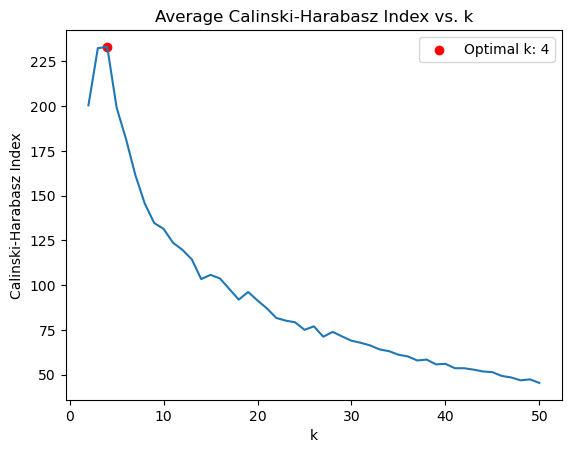

In [85]:
# plot Calinski-Harabasz index against k
plt.figure()
plt.plot(k_ch_score_dict.keys(), k_ch_score_dict.values())
plt.xlabel("k")
plt.ylabel("Calinski-Harabasz Index")
# mark the optimal point
plt.scatter(optimal_k_ch, k_ch_score_dict[optimal_k_ch], color='red', label=f"Optimal k: {optimal_k_ch}")
plt.title("Average Calinski-Harabasz Index vs. k")
plt.legend()

We see that the average Calinski-Harabasz index increases as we increase $k$, and then achieves a maxima at our optimal $k$. After this it appears to decrease in an almost monotone manner for $k$ greater than the optimal $k$, so it suggests our optimal $k$ is also a global maxima.

2.1.2

In order to judge the consistency between the clustering of our samples using $k$-means, we first need to extract our class labels.

In [86]:
# extract the tumour labels
true_labels = gene_expression_data["Type"].to_numpy()

We will compute the homogeneity score of the clustering to judge it. For a given set of classes $C$ and a set of clusters $K$ of size, where $|C|$ and $|K|$ are their respective sizes, the homogeneity score is given by:

\begin{align}
\mathrm{Homogeneity}\text{ } \mathrm{score} = 1 - \frac{H(C | K)}{H(C)},
\end{align}
where $H$ denotes the entropies:
\begin{align}
H(C | K) = - \sum_{k=1}^{|K|}\sum_{c=1}^{|C|}\frac{a_{ck}}{N}\mathrm{log}\left(\frac{a_{ck}}{\sum_{c=1}^{|C|}a_{ck}}\right), \quad H(C) = -\sum_{c=1}^{|C|}\frac{\sum_{k=1}^{|K|}a_{ck}}{N}\mathrm{log}\left(\frac{\sum_{k=1}^{|K|}a_{ck}}{N}\right).
\end{align}
In the above entropies, $N$ is the total number of data points, and $a_{ck}$ is the number of data points that belong to class $c$ and are assigned to cluster $k$.

We implement the calculation of the homogeneity score in `homogeneity_score()`, taking care that we do not take the logarithm of any zeroes.

In [87]:
def homogeneity_score(labels, clusters):
    """
    Compute the homogeneity score given cluster assignments and true class labels.
    Args:
        labels: n_samples numpy array of true class labels.
        clusters: n_samples numpy array of cluster assignments.
    Returns:
        homogeneity: the homogeneity score.
    """

    # create mapping between string labels and an assigned integer
    true_label_number_map = {label: i for i, label in enumerate(np.unique(labels))}
    # create mapping between cluster labels and cluster number
    cluster_number_map = {cluster: i for i, cluster in enumerate(np.unique(clusters))}
    # initialize the matrix A
    A = np.zeros((len(np.unique(labels)), len(np.unique(clusters))))
    # form A
    for label, cluster in zip(labels, clusters):
        A[true_label_number_map[label], cluster_number_map[cluster]] += 1

    # compute sums that appear in the formula
    sum_over_labels = np.sum(A, axis=0)
    sum_over_clusters = np.sum(A, axis=1)
    # compute the entropy H(C|K)
    conditional_entropy = 0
    for i in range(len(np.unique(labels))):
        for j in range(len(np.unique(clusters))):
            # avoid taking the log of 0
            if A[i, j] != 0:
                conditional_entropy -= A[i, j] * np.log(A[i, j]/sum_over_labels[j])
    # normalize by the number of samples
    conditional_entropy /= len(labels)

    # compute the entropy H(C)
    entropy = 0
    for i in range(len(np.unique(labels))):
        # avoid taking the log of 0
        if sum_over_clusters[i] != 0:
            entropy -= sum_over_clusters[i] * np.log(sum_over_clusters[i]/len(labels))
    # normalize by the number of samples
    entropy /= len(labels)
    # compute the homogeneity score
    homogeneity = 1 - conditional_entropy / entropy
    return homogeneity

We now compute the homogeneity score of our $k$-means clustering using the optimal $k$.

In [88]:
print(f"Homogeneity score of optimal clustering: {homogeneity_score(true_labels, optimal_clusters_ch)}")

Homogeneity score of optimal clustering: 0.58903040795848


The homogeneity score is a measure of how well the clusters in our cluster assignment contain data points of the same class, and is measured on a scale between 0 and 1, with a lower score indicating worse homogeneity in the clusters, and a higher score indicating greater cluster homogeneity. We get a score of around 0.589, which suggests that our clustering is not terrible but also not great in terms of homogeneity; it suggests that our cluster assignment has done reasonably well in grouping data points of the same type in its clusters, but there must be some clusters that contain multiple class labels. We can check explicitly which class labels belong to each cluster:

In [89]:
for cluster in np.unique(optimal_clusters_ch):
    print(f"Class labels in cluster {cluster}: {np.unique(true_labels[optimal_clusters_ch==cluster])}")

Class labels in cluster 0: ['KIRC']
Class labels in cluster 1: ['KIRC' 'LUAD' 'PRAD']
Class labels in cluster 2: ['BRCA' 'COAD' 'LUAD' 'PRAD']
Class labels in cluster 3: ['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']


We can see that we get only one fully homogeneous cluster, and three non-homogeneous clusters. Whilst the cluster assignment has not been able to completely segregate the sample tumour types as we would desire, it has still been able to separate some of the 'KIRC' tumour types into a single cluster.

One thing to bear in mind is that our optimal $k$ was 4, which is not equal to 5, the number of class labels. As a result of this, it is actually impossible for us to achieve a perfectly homogeneous cluster assignment, as at least one of the clusters must contain two different class labels. Also, it may be the case that the class label tumour type cannot be fully determined entirely from gene expression levels, or multiple class labels can have very similar gene expression levels, and so our clustering may sometimes fail to group them successfully.

#### 2.2 Graph-based analysis (20 marks)
2.2.1

We now move onto studying the structure of co-regulation among genes using our gene expression data.

First, we will compute the matrix of connected correlations between the genes, and use this as a similarity matrix to construct a graph that links genes together.

We then zero the diagonal terms, and perform thresholding with threshold = 0.75 on the absolute value of the entries. This is our adjacency matrix $\boldsymbol A$ of a weighted graph describing gene co-expression.

In [90]:
# initialize similarity matrix
correlation_matrix = np.corrcoef(gene_expression_matrix.T)

# initialize adjacency matrix
A = correlation_matrix.copy()
# fill the diagonal with zeros
np.fill_diagonal(A, 0)

# set all values with absolute value below the threshold 0.75 to zeros
A[np.abs(A) < 0.75] = 0

We visualize our adjacency matrix below in a heatmap.

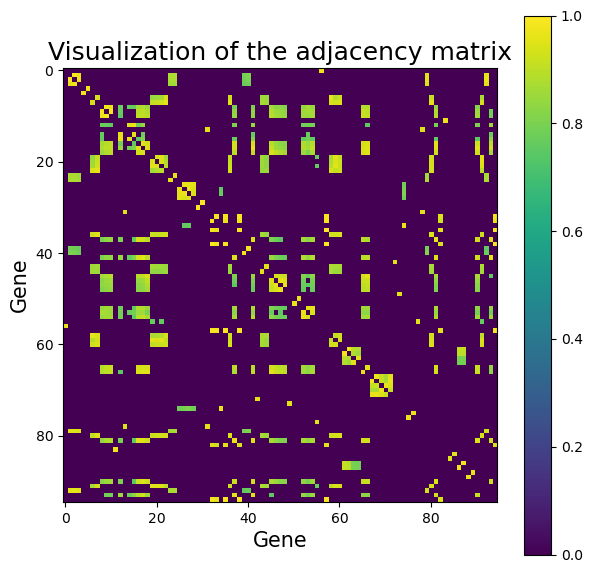

In [91]:
# plot heatmap of adjacency matrix
plt.figure(figsize=(7, 7))
plt.title("Visualization of the adjacency matrix", fontsize=18)
plt.imshow(A, cmap="viridis")
plt.xlabel("Gene", fontsize=15)
plt.ylabel("Gene", fontsize=15)
plt.colorbar()

2.2.2

We will now compute the degree centrality of each gene in our network. We identify the top 5 genes in terms of degree centrality, and return their indexes and their corresponding degree centralities, in descending centrality order. The degree centrality of node $i$, $c_d^{(i)}$, is given by:
\begin{align}
c_d^{(i)} &= \frac{d^{(i)}}{2E},\\
&= \frac{d^{(i)}}{\sum_i d^{(i)}},
\end{align}

where $d^{(i)}$ is the weighted degree of node $i$, and $E$ is the total number of sum of the weighted edges in the graph.

In [92]:
# get degree array
degree_array = A.sum(axis=1)
degree_centralities = degree_array / degree_array.sum()
sorted_gene_indexes = np.argsort(degree_centralities)[::-1]
# get top 5 degree centralities and their indexes in an array
top_5_centrality_array = np.hstack((sorted_gene_indexes[:5].reshape(-1,1), degree_centralities[sorted_gene_indexes[:5]].reshape(-1,1)))
# make into table
top_5_centrality_df = pd.DataFrame(top_5_centrality_array, index = ["1st highest", "2nd highest", "3rd highest", "4th highest", "5th highest"], columns = ["Gene index", "Degree Centrality"])
top_5_centrality_df

,Gene index,Degree Centrality
1st highest,17.0,0.026873
2nd highest,41.0,0.025935
3rd highest,16.0,0.025378
4th highest,81.0,0.025231
5th highest,90.0,0.024870


2.2.3

Next, we construct the symmetric normalised Laplacian, which is defined as:
\begin{align}
\boldsymbol L = \boldsymbol I - \boldsymbol D^{-\frac{1}{2}}\boldsymbol A \boldsymbol D^{-\frac{1}{2}},
\end{align}
where $\boldsymbol D$ is the diagonal matrix of node degrees, and $\boldsymbol A$ is the adjacency matrix we constructed before.

We can construct $\boldsymbol D$ by summing over the weighted edges connected to the node $i$, and setting this as the entry $\boldsymbol D_{ii}$.

In [93]:
# get inverse square root of degree array
degree_array_inverse_sqrt = 1.0 / np.sqrt(degree_array)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(degree_array_inverse_sqrt)

# define the normalized Laplacian
L_norm = np.eye(D_inv_sqrt.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt

We now derive the eigenvalues and eigenvectors of the symmetric normalised Laplacian $\boldsymbol L$, and plot its spectrum of eigenvalues.

We mark on the plot the gap between the zero and non-zero eigenvalues, upon numerical rounding; we class any eigenvalue with absolute value less than $10^{-14}$ as zero.

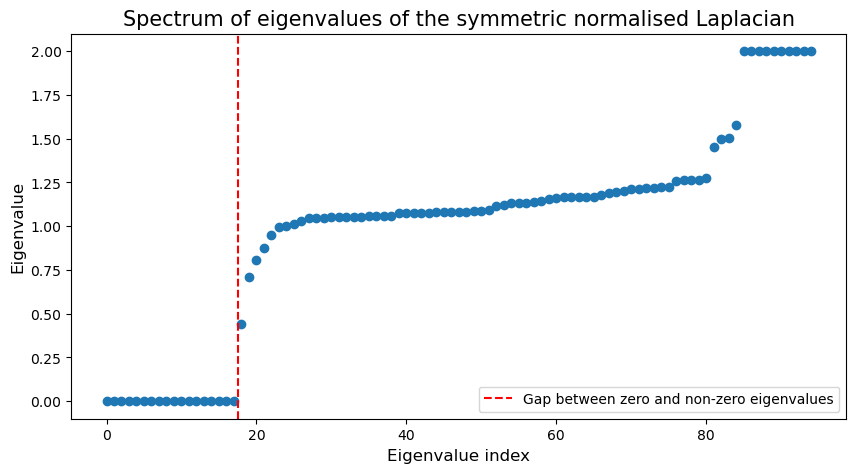

In [94]:
# get eigenvalues and eigenvectors of normalized Laplacian
eigenvalues, eigenvectors = scipy.linalg.eigh(L_norm)
# can cast to real values because eigenvalues are real since L_norm is symmetric
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
# get sorted eigenvalue indexes
sorted_eig_indexes = np.argsort(eigenvalues)
# sort eigenvalues in ascending order
sorted_eigenvalues = eigenvalues[sorted_eig_indexes]
# sort eigenvectors in ascending eigenvalue order
sorted_eigenvectors = eigenvectors[:, sorted_eig_indexes]
# calculate r
r = np.sum(np.abs(sorted_eigenvalues) < 1e-14)

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(sorted_eigenvalues)), sorted_eigenvalues)
# plot the gap between non-zero and zero eigenvalues
plt.axvline(x=r-0.5, color="red", linestyle="--", label="Gap between zero and non-zero eigenvalues")
plt.xlabel("Eigenvalue index", fontsize=12)
plt.ylabel("Eigenvalue", fontsize=12)
plt.title("Spectrum of eigenvalues of the symmetric normalised Laplacian", fontsize=15)
plt.legend()

Let us explicitly report the number of zero eigenvalues.

In [95]:
print(f"The number of zero eigenvalues r is {r}")

The number of zero eigenvalues r is 18


We get that there are 18 zero eigenvalues of the symmetric normalised Laplacian, which tells us that our network has 18 disconnected components; our network contains 18 subgraphs of connected genes, and these subgraphs themselves are not connected to each other.

2.2.4

We now define $\boldsymbol U$ as the 95 x $r$ matrix which takes the eigenvectors corresponding to eigenvalue zero as its columns. From $\boldsymbol U$ we form $\boldsymbol T$ by normalizing as follows:
\begin{align}
T_{ij} = \frac{U_{ij}}{\sqrt{\sum_k U_{ik}^2}}.
\end{align}

In [96]:
# construct U
U = sorted_eigenvectors[:, :r]
# construct T
T = U / np.sqrt(np.square(U).sum(axis=1, keepdims=True))

Now, we will use the normalized within-cluster distance as a metric for our $k$-means, which is defined as:
\begin{align}
W &= \frac{1}{2}\sum_{l=1}^k \frac{1}{|c_l|} \sum_{i, j \in c_l} \left\|\boldsymbol x^{(i)} - \boldsymbol x^{(j)}\right\|^2\\
&= \sum_{l=1}^k\sum_{i \in c_l}\left\|\boldsymbol x^{(i)} - \boldsymbol m_l \right\|^2,\quad \text{as shown in the lecture notes.}
\end{align}

This is implemented in `normalized_within_distance()`.

In [97]:
def normalized_within_distance(T, labels, centroids):
    """
    Compute the normalized within-cluster distance of a given clustering.
    Args:
        T: n_nodes x n_components numpy array of data.
        labels: n_nodes numpy array of cluster labels.
        centroids: k x n_components numpy array of cluster centroids.
    Returns:
        W: float, the total within-cluster distance.
    """
    # initialize the total within-cluster distance
    W = 0
    for label in np.unique(labels):
        # get the data points in the cluster
        within_cluster_data = T[labels==label]
        # compute the squared distance between the data points and the centroid
        within_cluster_squared_distance_sum = np.square(np.linalg.norm(within_cluster_data - centroids[label])).sum()
        # add to the total within-cluster distance
        W += within_cluster_squared_distance_sum
    return W

Now, we can use this function and our previously defined `k_means()` function to determine what the optimal $k$ is to use for clustering. Once again we do this by running $k$-means for each $k$ with 1000 different initialisations, but this time calculating the minimum of the normalized within-cluster distance of the corresponding 1000 clusterings; we take the minimum as we want the global minimum normalized within-cluster distance, and there could potentially be local minima. Whilst 1000 different initialisations may seem like a lot, it is important to ensure we achieve global minima for each $k$. Below the funciton `optimize_k_nwd()` does this for a given range of $k$'s, and stores the average normalized within-cluster distance in a dictionary mapping.

In [98]:
def optimize_k_nwd(T, k_range):
    """
    Find the average normalized within-cluster distance index over
    5 different initializations for each k in k_range.
    Args:
        T: n_nodes x n_components numpy array of data.
        k_range: range of k values to test.
    Returns:
        k_scores: dictionary of k values and their corresponding average
        normalized within-cluster index.
    """
    # initialize dict
    k_scores = {}
    for k in k_range:
        scores = []
        # run k-means 5 times for each k to get 5 different initializations
        for i in range(1000):
            labels, centroids = k_means(T, k, print_its=False)
            # append score
            scores.append(normalized_within_distance(T, labels, centroids))
        # add average score to dict
        k_scores[k] = min(scores)
        print(f"k={k}, minimum normalized within-cluster distance: {k_scores[k]}")
    return k_scores

We call this function for $k \in [2, 95]$. We have selected as large a range as we can, going from a binary clustering at $k=2$ to isolated clustering when $k=95$.

Note again we only print the minimum value for each $k$, and not for every iteration of $k$-means performed, as this caused a huge printing log (HTML would not upload).

In [99]:
np.random.seed(2)
k_nwd_score_dict = optimize_k_nwd(T, np.arange(2, 96))

k=2, minimum normalized within-cluster distance: 64.61111111111124
k=3, minimum normalized within-cluster distance: 51.07142857142867
k=4, minimum normalized within-cluster distance: 42.85106382978727
k=5, minimum normalized within-cluster distance: 36.34999999999999
k=6, minimum normalized within-cluster distance: 30.764705882352935
k=7, minimum normalized within-cluster distance: 25.357142857142872
k=8, minimum normalized within-cluster distance: 22.400000000000006
k=9, minimum normalized within-cluster distance: 18.823529411764717
k=10, minimum normalized within-cluster distance: 16.00000000000001
k=11, minimum normalized within-cluster distance: 14.571428571428601
k=12, minimum normalized within-cluster distance: 12.399999999999963
k=13, minimum normalized within-cluster distance: 9.999999999999957
k=14, minimum normalized within-cluster distance: 7.999999999999973
k=15, minimum normalized within-cluster distance: 5.999999999999974
k=16, minimum normalized within-cluster distance: 

Let us plot the average normalized within-cluster distance as a function of $k$, and use the elbow method to set an appropriate value of $k$. The elbow method refers to identifying the point where diminishing returns are no longer worth the additional cost; the point where adding more clusters does not significantly decrease the normalized within-cluster distance in the $k$-means clustering.

We mark on the plot where we take to be the elbow.

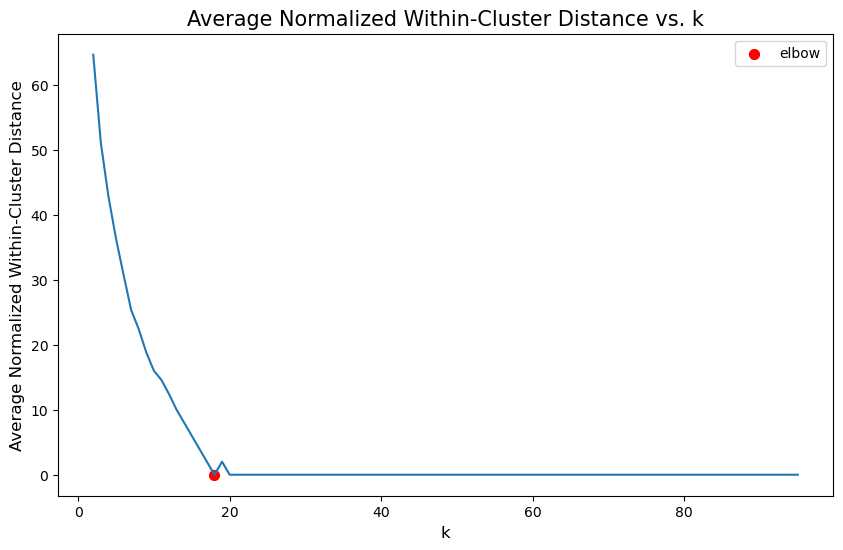

In [100]:
# plot within-cluster distance against k
plt.figure(figsize=(10,6))
plt.plot(k_nwd_score_dict.keys(), k_nwd_score_dict.values())
# mark elbow point
plt.scatter(18, k_nwd_score_dict[18], color="red", label="elbow", s=50)
plt.xlabel("k", fontsize=12)
plt.ylabel("Average Normalized Within-Cluster Distance", fontsize=12)
plt.title("Average Normalized Within-Cluster Distance vs. k", fontsize=15)
plt.legend()

From the graph, we see the 'elbow' appears to be at around $k=18$, and so we can take this as a suitable value of $k$.

We can obtain the clustering corresponding to this $k$ below.

In [101]:
np.random.seed(0)
# run k-means with elbow k
optimal_clusters_nwd = k_means(T, 18)[0]

Iteration: 0
71.578947% labels changed
Iteration: 1
6.315789% labels changed
Iteration: 2
Labels unchanged! Terminating k-means.


We explictly report the optimal cluster assignment below.

In [102]:
optimal_clusters_nwd

array([ 5, 10, 10, 10, 12, 12, 15, 15, 16, 16, 16,  4, 16, 11, 16, 16, 16,
       16, 16, 15, 15, 15, 15, 10, 10,  2,  2,  2,  2,  1,  1, 11,  8,  8,
        2,  8, 15, 16,  8, 10, 10, 16, 17, 15, 15, 16, 16, 16, 16,  6,  5,
        5, 16, 16, 16, 15,  5,  8, 15, 15, 15,  1,  1,  1,  1, 16, 16,  0,
        0,  0,  0,  0, 17,  6,  2,  7,  7, 15, 11, 10, 15, 16,  8,  4,  3,
        3,  1,  1,  9,  9, 16, 15, 10, 16,  8])

Finding our $k=18$ implies that in terms of average normalized within-cluster distance, it is suitable to partition our genes into 18 clusters. This aligns with the fact that the symmetric normalized Laplacian had 18 zero eigenvalues which implied there were 18 disconnected components in our network; the clustering with minimal within-cluster distance found using this $k$ could correspond to the disconnected components of our network.

2.2.5

Now, we are instructed to find the largest cluster in the clustering found using the $k$ in the previous question.

In [103]:
# get the cluster sizes
cluster_indexes, cluster_sizes = np.unique(optimal_clusters_nwd, return_counts=True)
biggest_cluster_size = np.max(cluster_sizes) # find max size
print(f"Biggest cluster size = {biggest_cluster_size}")

Biggest cluster size = 23


We would like to perform spectral partitioning on the subgraph corresponding to this cluster, and so we first slice out the adjacency matrix of this subgraph, and compute its corresponding symmetric normalised Laplacian.

In [104]:
# get index of biggest cluster
biggest_cluster_index = cluster_indexes[cluster_sizes==biggest_cluster_size][0]
# get indexes of genes in the biggest cluster
cluster_gene_indexes = np.argwhere(optimal_clusters_nwd==biggest_cluster_index).flatten()

# slice out new adjacency matrix
cluster_A = A[cluster_gene_indexes][:, cluster_gene_indexes]

# get degree array
cluster_degree_array = cluster_A.sum(axis=1)

# get inverse square root of degree array
cluster_degree_array_inverse_sqrt = 1.0 / np.sqrt(cluster_degree_array)

# set a diagonal matrix of the inverse square root of degree
cluster_D_inv_sqrt = np.diag(cluster_degree_array_inverse_sqrt)

# define the normalized Laplacian
cluster_L_norm = np.eye(cluster_D_inv_sqrt.shape[0]) - cluster_D_inv_sqrt @ cluster_A @ cluster_D_inv_sqrt

In order to perform spectral partitioning we must find the optimal solution to the optimization problem:
\begin{align}
\min_{\boldsymbol s \in \{-1,1\}^N}\boldsymbol s^T L \boldsymbol s \quad \text{under the constraints}\begin{cases}\boldsymbol s^T \cdot \boldsymbol s &= n_1 + n_2 = N \\\boldsymbol s^T \cdot \boldsymbol 1 &= n_1 - n_2\end{cases},
\end{align}
where $n_1, n_2$ are the respective sizes of the partitions.

To find the optimal solution, it is shown in the lecture notes that first we are required to find the $\textit{Fiedler}$ eigenvector $\boldsymbol v_2$; this is the eigenvector corresponding to the first non-trivial (non-zero) eigenvalue when sorted in ascending order. The optimal solution to the relaxed optimization over $\mathbb{R}^N$ is then given by $\boldsymbol s^* = \boldsymbol v_2 + \frac{n_1-n_2}{N} \boldsymbol 1$.

Once we obtain $\boldsymbol v_2 = (v_2^{(1)}, \dots, v_2^{(N)})$, in order to maxmise the alignment of our solution over $\{-1,1\}^N$ with the relaxed solution found over $\mathbb{R}^N$, we can assign all elements with $v_2^{(i)} \leq 0$ to cluster index 0, and $v_2^{(i)} > 0$ to cluster index 1. This is our spectral partition.

Below, `spectral_partition()` is implemented to perform these steps. Again, we class any eigenvalue with absolute value less than $10^{-14}$ as zero

In [105]:
def spectral_partition(L):
    # get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = scipy.linalg.eigh(L)
    # find the smallest non-trivial eigenvalue considering numerical rounding
    smallest_non_trivial_eigenvalue = np.sort(eigenvalues[np.abs(eigenvalues) > 1.0e-14])[0]
    # get the eigenvector corresponding to the smallest non-trivial eigenvalue
    fiedler_eigenvector = eigenvectors[:, np.argwhere(eigenvalues == smallest_non_trivial_eigenvalue)[0]]
    # intialize labels array
    labels = np.zeros_like(fiedler_eigenvector)
    # set all positive values to cluster 1, otherwise cluster 0
    labels[fiedler_eigenvector > 0] = 1
    return labels

We perform our spectral partition on the subgraph by passing in its symmetric normalised Laplacian.

In [106]:
partition_labels = spectral_partition(cluster_L_norm).flatten()

Now, we visualize the magnitudes of the network links within each partition, and across the two, using histograms.

(0.0, 1.0)

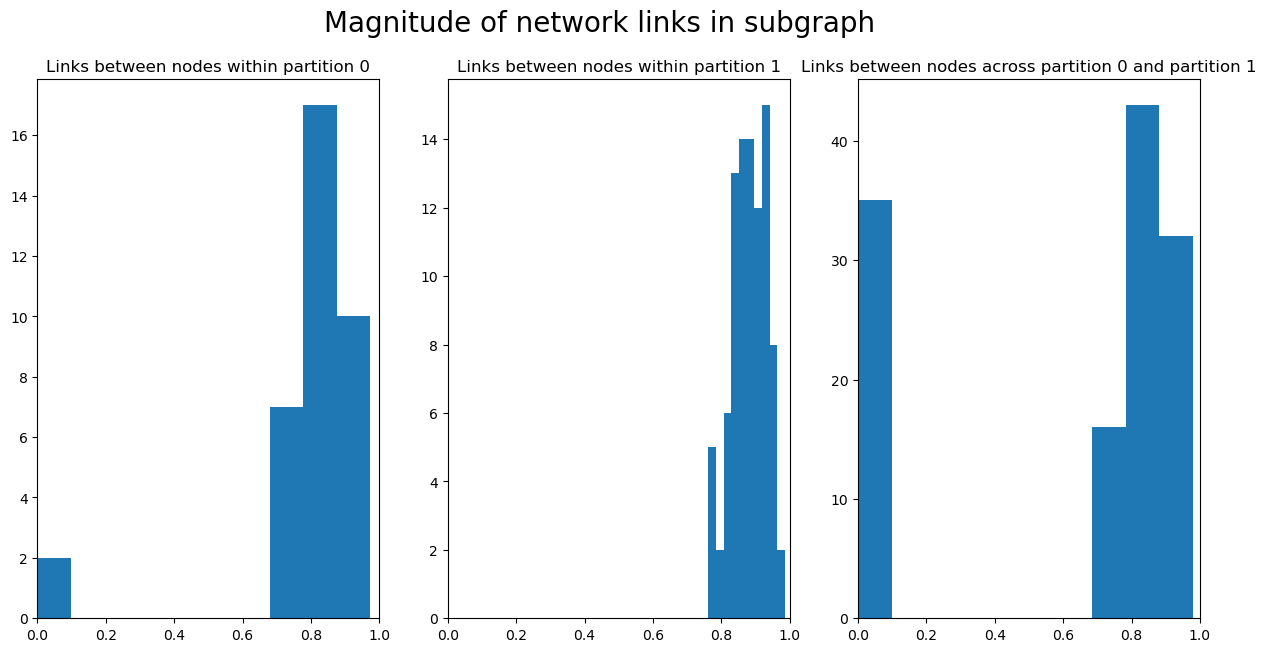

In [107]:
# initialize lists to store link weights
link_weights_00 = []
link_weights_11 = []
link_weights_01 = []
# loop over upper triangle of A to avoid repeating links
for i in range(cluster_A.shape[0]):
    for j in range(0, i):
        # link weights between nodes in partition 0
        if partition_labels[i] == 0 and partition_labels[j] == 0:
            link_weights_00.append(cluster_A[i, j])
        # link weights between nodes in partition 1
        elif partition_labels[i] == 1 and partition_labels[j] == 1:
            link_weights_11.append(cluster_A[i, j])
        # link weights between nodes in partition 0 and partition 1
        elif partition_labels[i] == 0 and partition_labels[j] == 1:
            link_weights_01.append(cluster_A[i, j])
        elif partition_labels[i] == 1 and partition_labels[j] == 0:
            link_weights_01.append(cluster_A[i, j])

# plot histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle("Magnitude of network links in subgraph", fontsize=20)
axs[0].set_title("Links between nodes within partition 0", fontsize=12)
axs[0].hist(link_weights_00)
axs[1].set_title("Links between nodes within partition 1", fontsize=12)
axs[1].hist(link_weights_11)
axs[2].set_title("Links between nodes across partition 0 and partition 1", fontsize=12)
axs[2].hist(link_weights_01)
axs[0].set_xlim(0, 1)
axs[1].set_xlim(0, 1)
axs[2].set_xlim(0, 1)

We see that our links between nodes within partition 0 mainly consist of links with high weights (between 0.7 and 1.0), and similarly for links between nodes within partition 1, which all have weights over 0.7. Most of these within partition links are high weight, which is what we expect as our spectral partition should partition the graph in a way so we do not have to remove many links of high weight.

We see that on the histogram on the right, we have many links across the two partitions with very low weight (less than 0.1), which suggests that most of the links required to be removed to create the partition are of low weight, as we would hope. Although there exist are also some high weight links that need to be removed, this is likely unavoidable as we are unlikely to be able to find a partition that only removes low weight links across the partition components.

2.2.6

Let us now compute the degree centrality of each node in the subgraph, and like we did previously, we identify the top 5 genes in terms of degree centrality, and return their indexes and their corresponding degree centralities, in descending centrality order. Again we use the formula:
\begin{align}
c_d^{(i)} = \frac{d^{(i)}}{\sum_i d^{(i)}}.
\end{align}

In [108]:
cluster_degree_centralities = cluster_degree_array / cluster_degree_array.sum()
# get sorted indexes of degree centralities in descending order in subgraph
cluster_sorted_gene_indexes = np.argsort(cluster_degree_centralities)[::-1]
# map these subgraph gene indexes to their gene indexes in the complete graph
mapped_cluster_sorted_gene_indexes = np.array([cluster_gene_indexes[subidx] for subidx in cluster_sorted_gene_indexes])
# get top 5 degree centralities and their indexes in an array
top_5_centrality_array_2 = np.hstack((mapped_cluster_sorted_gene_indexes[:5].reshape(-1,1), cluster_degree_centralities[cluster_sorted_gene_indexes[:5]].reshape(-1,1)))
# make into dataframe
top_5_centrality_df_2 = pd.DataFrame(top_5_centrality_array_2, index = ["1st highest", "2nd highest", "3rd highest", "4th highest", "5th highest"], columns = ["Gene index", "Degree Centrality"])
top_5_centrality_df_2

,Gene index,Degree Centrality
1st highest,17.0,0.052890
2nd highest,41.0,0.051044
3rd highest,16.0,0.049948
4th highest,81.0,0.049657
5th highest,90.0,0.048948


Let us combine this degree centrality table of the subgraph with the degree centrality table we found for the entire graph.

In [109]:
# combine the two tables
top_5_centrality_combined_array = np.vstack((top_5_centrality_array, top_5_centrality_array_2))
top_5_centrality_combined_df = pd.DataFrame(top_5_centrality_combined_array, index = ["1st highest (entire graph)", "2nd highest (entire graph)", "3rd highest (entire graph)", "4th highest (entire graph)", "5th highest (entire graph)", "1st highest (subgraph)", "2nd highest (subgraph)", "3rd highest (subgraph)", "4th highest (subgraph)", "5th highest (subgraph)"], columns = ["Gene index", "Degree Centrality"])
top_5_centrality_combined_df

,Gene index,Degree Centrality
1st highest (entire graph),17.0,0.026873
2nd highest (entire graph),41.0,0.025935
3rd highest (entire graph),16.0,0.025378
4th highest (entire graph),81.0,0.025231
5th highest (entire graph),90.0,0.024870
1st highest (subgraph),17.0,0.052890
2nd highest (subgraph),41.0,0.051044
3rd highest (subgraph),16.0,0.049948
4th highest (subgraph),81.0,0.049657
5th highest (subgraph),90.0,0.048948


We see that the top 5 gene indexes in our subgraph are the same as in our entire graph; the 5 genes with the highest degree centrality are all in the largest cluster we found by $k$-means. This may be due to the fact that high degree centrality is the result of the node having high degree, and so it is likely that these nodes with high connectivity are connected to each other in same cluster.

The reason that the degree centralities of these top 5 nodes are higher in the subgraph is that most of their weighted edge connections are preserved since they are all contained in the subgraph, but the total sum of the weighted edge connections is less in the subgraph since the connections to the other clusters have been removed; therefore the degree centralities are higher in the subgraph nodes.

<a class="anchor" id="references"></a>
### References
[1] Dahl, George E., Tara N. Sainath, and Geoffrey E. Hinton. "Improving Deep Neural Networks for LVCSR Using Rectified Linear Units and Dropout". In 2013 IEEE International Conference on Acoustics, Speech and Signal Processing, 8609–13, 2013. https://doi.org/10.1109/ICASSP.2013.6639346.

[2] Lee, Daniel, and H. Sebastian Seung. "Algorithms for non-negative matrix factorization." Advances in neural information processing systems 13 (2000).

[3] Lee, Daniel, and H. Seung. "Learning the Parts of Objects by Non-Negative Matrix Factorization". Nature 401 (11 1999): 788–91. https://doi.org/10.1038/44565.

[4] Penrose, R. "On Best Approximate Solutions of Linear Matrix Equations". Mathematical Proceedings of the Cambridge Philosophical Society 52, no. 1 (1956): 17–19. https://doi.org/10.1017/S0305004100030929.

[5] Saitta, Sandro, Benny Raphael, and Ian FC Smith. "A comprehensive validity index for clustering." Intelligent Data Analysis 12, no. 6 (2008): 529-548.